In [78]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from node2vec import Node2Vec
import networkx.algorithms.community as nx_comm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score


In [2]:
# Load the CSV files into Python
network_power_df = pd.read_csv('network_power.csv')
post_counts_df = pd.read_csv('post_counts.csv')
countries_df = pd.read_csv('countries.csv')
country_attributes_df = pd.read_csv('country_attributes.csv')

In [3]:
## POST COUNTS

def create_graphs(post_counts_df, countries_df, country_attributes_df):
    # Create a dictionary to store the graphs by year
    graphs_by_year = {}
    
    # Merge post_counts_df with countries_df to get subregion and subregionColour
    post_counts_df = post_counts_df.merge(countries_df[['id', 'subregion', 'subregionColour']], 
                                          left_on='COUNTRY', right_on='id', how='left')
    post_counts_df = post_counts_df.merge(countries_df[['id', 'subregion', 'subregionColour']], 
                                          left_on='POST COUNTRY', right_on='id', how='left', 
                                          suffixes=('', '_POST'))
    
    # Split country_attributes_df by year
    attributes_by_year = country_attributes_df.groupby('Year')
    
    for year, attributes_df in attributes_by_year:
        # Filter post_counts_df for the current year
        yearly_posts = post_counts_df[post_counts_df['Year'] == year]
        
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes with attributes
        for _, row in countries_df.iterrows():
            country_id = row['id']
            G.add_node(country_id, subregion=row['subregion'], subregionColour=row['subregionColour'])
        
        # Update nodes with yearly attributes
        for _, row in attributes_df.iterrows():
            country_id = row['COUNTRY']
            if country_id in G.nodes:
                G.nodes[country_id].update({
                    'POPULATION (M)': row['POPULATION (M)'],
                    'GDP (B, USD)': row['GDP (B, USD)'],
                    'G20 RANK': row['G20 RANK'],
                    'OECD RANK': row['OECD RANK'],
                    'ASIA RANK': row['ASIA RANK'],
                    'OVERALL RANK': row['OVERALL RANK']
                })
        
        # Add edges with weights
        for _, row in yearly_posts.iterrows():
            G.add_edge(row['COUNTRY'], row['POST COUNTRY'], weight=row['POST COUNT'])
        
        # Store the graph in the dictionary
        graphs_by_year[year] = G
    
    return graphs_by_year

graphs = create_graphs(post_counts_df, countries_df, country_attributes_df)

# Accessing individual graphs
posts_2016 = graphs.get(2016)
posts_2017 = graphs.get(2017)
posts_2019 = graphs.get(2019)
posts_2021 = graphs.get(2021)
posts_2023 = graphs.get(2023)

# Export function
# def export_graphs(graphs):
#     for year, graph in graphs.items():
#         filename = f"{year}.gexf"
#         nx.write_gexf(graph, filename)
#         print(f"Graph for {year} exported to {filename}")

# export_graphs(graphs_by_year)

In [4]:
# Function to get general info about a graph
def get_graph_info(graph):
    """
    Retrieve edges with weights and nodes with attributes from a graph.

    Parameters:
    graph (nx.Graph): The graph to retrieve information from.

    Returns:
    dict: A dictionary containing nodes and edges information.
    """
    edges_with_weights = list(graph.edges(data=True))
    nodes_with_attributes = list(graph.nodes(data=True))

    return {
        'edges': edges_with_weights,
        'nodes': nodes_with_attributes
    }

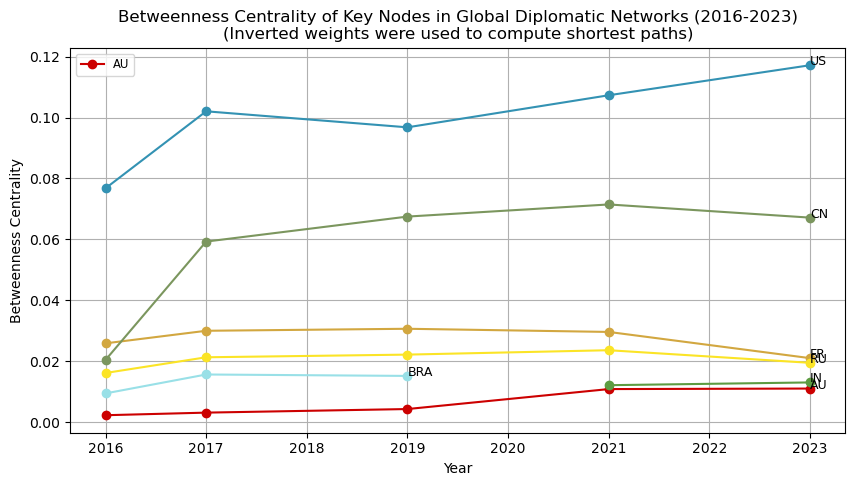

In [5]:
# Function to invert edge weights
def invert_weights(graph):
    transformed_graph = graph.copy()
    for u, v, d in transformed_graph.edges(data=True):
        d['transformed_weight'] = 1 / d['weight'] if d['weight'] != 0 else 0
    return transformed_graph
    
# Function to compute and display betweenness centrality
def compute_betweenness_centrality(graph, year):
    
    graph = invert_weights(graph)
    
    betweenness_centrality = nx.betweenness_centrality(graph, weight='transformed_weight')
    sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
    
    # Find the position of Australia (AU) and the nodes either side
    au_index = [i for i, (node, _) in enumerate(sorted_betweenness) if node == 'AU'][0]
    context_nodes = sorted_betweenness[max(0, au_index):min(len(sorted_betweenness), au_index+1)]
    
    top_5_nodes = sorted_betweenness[:5]
    
    # Extract subregion and subregionColour
    top_5_nodes = [(node, centrality, graph.nodes[node]['subregion'], graph.nodes[node]['subregionColour']) for node, centrality in top_5_nodes]
    context_nodes = [(node, centrality, graph.nodes[node]['subregion'], graph.nodes[node]['subregionColour']) for node, centrality in context_nodes]
    
    return {
        'year': year,
        'top_5_nodes': top_5_nodes,
        'context_nodes': context_nodes
    }

# Add node attributes and compute betweenness centrality for each year
results = []
for year, graph in graphs.items():
    results.append(compute_betweenness_centrality(graph, year))
    
# Create a dictionary to store centrality data
centrality_data = {}
for result in results:
    year = result['year']
    for node, centrality, subregion, subregionColour in result['top_5_nodes'] + result['context_nodes']:
        if node not in centrality_data:
            centrality_data[node] = {'years': [], 'centrality': [], 'subregion': subregion, 'subregionColour': subregionColour}
        centrality_data[node]['years'].append(year)
        centrality_data[node]['centrality'].append(centrality)

# Plot the betweenness centrality data
plt.figure(figsize=(10, 5))
for node, data in centrality_data.items():
    plt.plot(data['years'], data['centrality'], marker='o', label=node if node == 'AU' else "", color=data['subregionColour'])
    plt.text(data['years'][-1], data['centrality'][-1], node, fontsize=9)

plt.xlabel('Year')
plt.ylabel('Betweenness Centrality')
plt.title('Betweenness Centrality of Key Nodes in Global Diplomatic Networks (2016-2023)\n(Inverted weights were used to compute shortest paths)')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True)

# plt.savefig('betweenness_centrality.png', format='png', dpi=300)  # Save as PNG with 300 DPI resolution

plt.show()

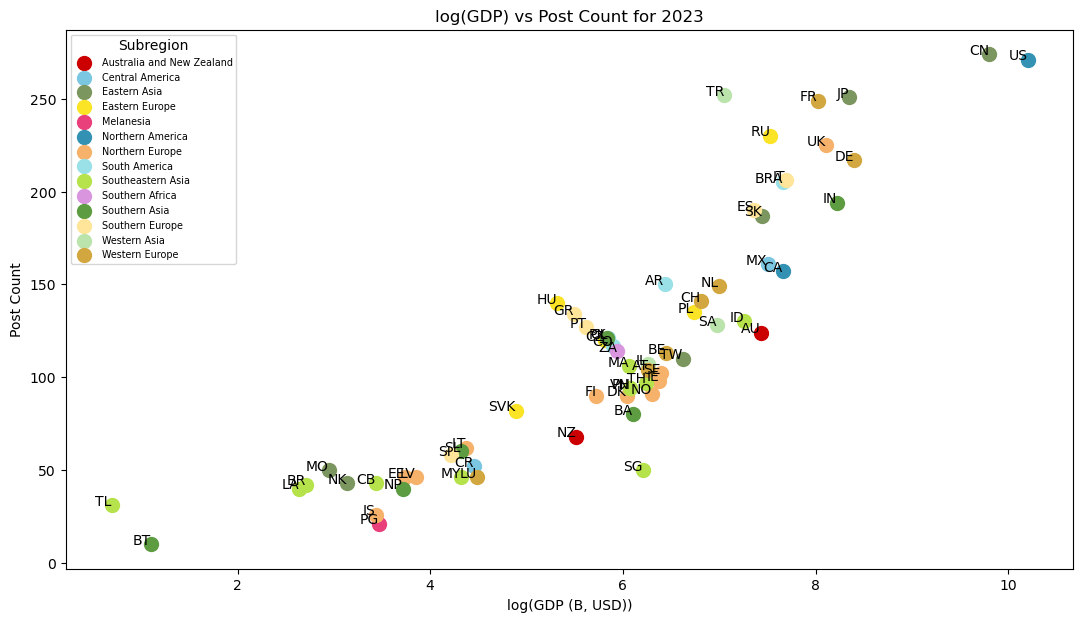

In [6]:
# Group by 'COUNTRY' and sum only the 'POST COUNT' column
post_counts_2023_grouped = post_counts_df[post_counts_df['Year'] == 2023].groupby('COUNTRY')['POST COUNT'].sum().reset_index()

# Filter country attributes for the year 2023
country_attributes_2023 = country_attributes_df[country_attributes_df['Year'] == 2023]

# Merge with post_counts_2023_grouped to get POST COUNT, GDP (B, USD), and POPULATION (M)
merged_data = pd.merge(country_attributes_2023[['COUNTRY', 'GDP (B, USD)', 'POPULATION (M)']], post_counts_2023_grouped, on='COUNTRY', how='inner')

# Merge with countries to get subregion and subregionColour
final_data = pd.merge(merged_data, countries_df[['id', 'subregion', 'subregionColour']], left_on='COUNTRY', right_on='id', how='left')

# Filter out the rows where subregion is 'European Union'
final_data_filtered = final_data[final_data['subregion'] != 'European Union']

# Plot the data with log(GDP) on the x-axis and POST COUNT on the y-axis
plt.figure(figsize=(13, 7))

# Scatter plot with subregion colors
for subregion, data in final_data_filtered.groupby('subregion'):
    plt.scatter(data['GDP (B, USD)'].apply(lambda x: np.log(x)), data['POST COUNT'], 
                color=data['subregionColour'].values[0], label=subregion, s=100)

# Add labels for each point
for i, row in final_data_filtered.iterrows():
    plt.text(np.log(row['GDP (B, USD)']), row['POST COUNT'], row['COUNTRY'], fontsize=10, ha='right')

# Set the labels and title
plt.xlabel('log(GDP (B, USD))')
plt.ylabel('Post Count')
plt.title('log(GDP) vs Post Count for 2023')

# Create a  legend inside the top left of the graph
plt.legend(loc='upper left', fontsize='x-small', title='Subregion')

# plt.savefig('log(GDP)_vs_Post Count_2023_2.png', format='png', dpi=500)  # Save as PNG with 300 DPI resolution

plt.show()

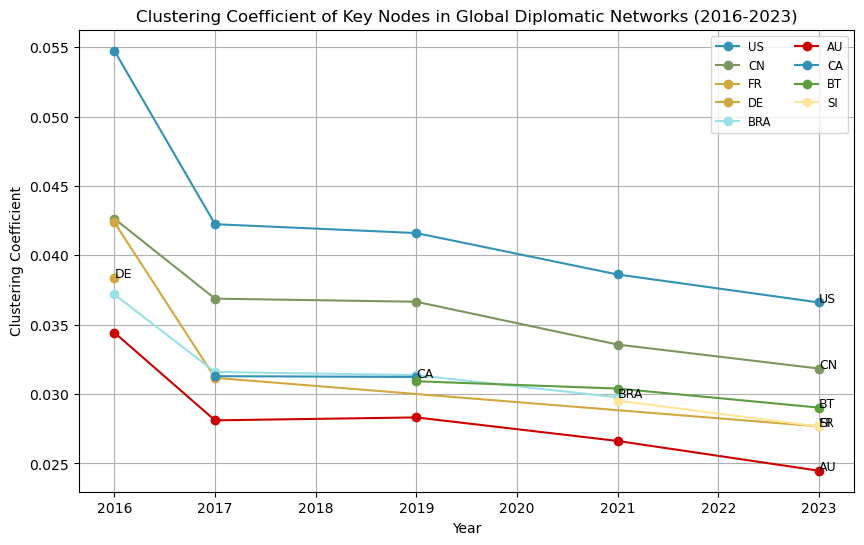

In [7]:
# Function to compute and display clustering coefficient
def compute_clustering_coefficient_filtered(graph, year):
    # Identify nodes with outgoing edges
    outgoing_nodes = {node for node in graph.nodes if graph.out_degree(node) > 0}
    
    # Create a subgraph with only nodes that have outgoing edges
    subgraph = graph.subgraph(outgoing_nodes)
    
    clustering_coeffs = nx.clustering(subgraph, weight='weight')
    sorted_clustering = sorted(clustering_coeffs.items(), key=lambda item: item[1], reverse=True)
    
    # Include Australia (AU) in the top nodes if not already present
    top_5_nodes = sorted_clustering[:5]
    if 'AU' not in [node for node, _ in top_5_nodes]:
        for node, clustering in sorted_clustering:
            if node == 'AU':
                top_5_nodes.append((node, clustering))
                break
    
    # Extract subregion and subregionColour
    top_5_nodes = [(node, clustering, graph.nodes[node]['subregion'], graph.nodes[node]['subregionColour']) for node, clustering in top_5_nodes]
    
    return {
        'year': year,
        'top_5_nodes': top_5_nodes
    }

# Add node attributes and compute clustering coefficient for each year
results = []
for year, graph in graphs.items():
    results.append(compute_clustering_coefficient_filtered(graph, year))

# Create a dictionary to store clustering data
clustering_data = {}
for result in results:
    year = result['year']
    for node, clustering, subregion, subregionColour in result['top_5_nodes']:
        if node not in clustering_data:
            clustering_data[node] = {'years': [], 'clustering': [], 'subregion': subregion, 'subregionColour': subregionColour}
        clustering_data[node]['years'].append(year)
        clustering_data[node]['clustering'].append(clustering)

# Plot the clustering coefficient data
plt.figure(figsize=(10, 6))
for node, data in clustering_data.items():
    plt.plot(data['years'], data['clustering'], marker='o', label=node, color=data['subregionColour'])
    plt.text(data['years'][-1], data['clustering'][-1], node, fontsize=9)

plt.xlabel('Year')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient of Key Nodes in Global Diplomatic Networks (2016-2023)')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True)
plt.show()

In [8]:
# Declining clustering coefficient probably because of new nodes added to the network 

# Initialise dictionaries to store outgoing nodes and new additions for each year
outgoing_nodes_by_year = {}
new_additions_by_year = {}

# Function to get nodes with outgoing edges for a given graph
def get_outgoing_nodes(graph):
    return {node for node in graph.nodes if graph.out_degree(node) > 0}

# Compute outgoing nodes for each year and track new additions
previous_outgoing_nodes = set()
for year, graph in graphs.items():
    current_outgoing_nodes = get_outgoing_nodes(graph)
    outgoing_nodes_by_year[year] = current_outgoing_nodes
    new_additions_by_year[year] = current_outgoing_nodes - previous_outgoing_nodes
    previous_outgoing_nodes = current_outgoing_nodes

# Print the outgoing nodes and new additions for each year
for year in sorted(outgoing_nodes_by_year.keys()):
    print(f"Year: {year}")
    print(f"Outgoing Nodes: {outgoing_nodes_by_year[year]}")
    print(f"New Additions: {new_additions_by_year[year]}")
    print()

Year: 2016
Outgoing Nodes: {'HU', 'NO', 'IE', 'SI', 'ID', 'FR', 'CN', 'AR', 'IL', 'ZA', 'UK', 'IT', 'PT', 'DK', 'IN', 'SK', 'CL', 'EE', 'IS', 'LU', 'US', 'TR', 'JP', 'BE', 'GR', 'NZ', 'SA', 'SVK', 'AU', 'ES', 'DE', 'CZ', 'NL', 'MX', 'SE', 'AT', 'PL', 'FI', 'CH', 'CA', 'BRA', 'RU'}
New Additions: {'HU', 'NO', 'IE', 'SI', 'ID', 'FR', 'CN', 'AR', 'IL', 'ZA', 'UK', 'IT', 'PT', 'DK', 'IN', 'SK', 'CL', 'EE', 'IS', 'LU', 'US', 'TR', 'JP', 'BE', 'GR', 'NZ', 'SA', 'SVK', 'AU', 'ES', 'DE', 'CZ', 'NL', 'MX', 'SE', 'AT', 'PL', 'FI', 'CH', 'CA', 'BRA', 'RU'}

Year: 2017
Outgoing Nodes: {'PH', 'CB', 'HU', 'NO', 'IE', 'SI', 'TW', 'CN', 'BA', 'AR', 'FR', 'ID', 'IL', 'PK', 'UK', 'VN', 'ZA', 'IT', 'PT', 'MA', 'DK', 'IN', 'SK', 'CL', 'LV', 'EE', 'IS', 'LU', 'NP', 'US', 'TR', 'JP', 'BE', 'GR', 'NZ', 'SA', 'SVK', 'BT', 'AU', 'SL', 'ES', 'SG', 'DE', 'TH', 'NK', 'MO', 'CZ', 'NL', 'MX', 'SE', 'AT', 'PL', 'BR', 'LA', 'FI', 'MY', 'CH', 'CA', 'BRA', 'RU'}
New Additions: {'PK', 'NP', 'VN', 'PH', 'BR', 'CB', 'LA',

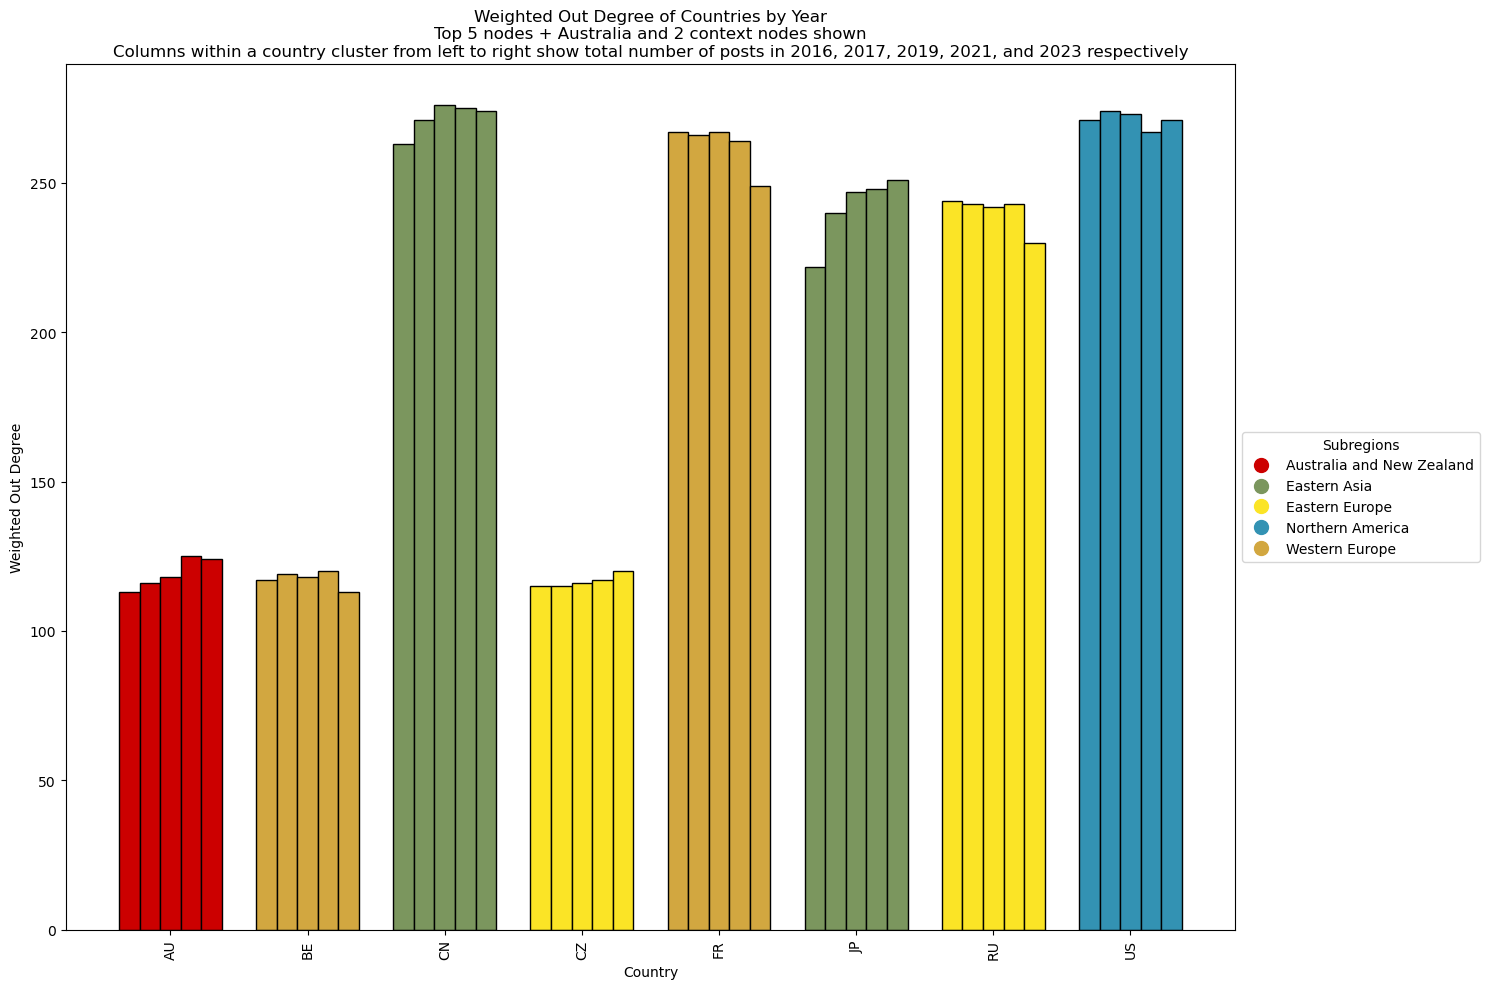

In [9]:
# Function to get nodes with outgoing edges and their weighted out-degrees for a given graph
def get_weighted_out_degrees(graph):
    weighted_out_degrees = {node: graph.out_degree(node, weight='weight') for node in graph.nodes if graph.out_degree(node) > 0}
    return weighted_out_degrees

# Initialise a dictionary to store the results
out_degrees_by_year = {}

# Compute the weighted out-degrees for each year
for year, graph in graphs.items():
    out_degrees_by_year[year] = get_weighted_out_degrees(graph)

# Collect data for plotting
data = []
for year, out_degrees in out_degrees_by_year.items():
    for node, out_degree in out_degrees.items():
        subregion = graph.nodes[node]['subregion']
        subregion_colour = graph.nodes[node]['subregionColour']
        data.append([year, node, out_degree, subregion, subregion_colour])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Year', 'Country', 'OutDegree', 'Subregion', 'SubregionColour'])

# Identify top 4 countries by out-degree and countries with similar out-degrees to Australia
top_countries = df.groupby('Country')['OutDegree'].sum().nlargest(5).index.tolist()
au_out_degrees = df[df['Country'] == 'AU'].groupby('Country')['OutDegree'].sum().values[0]

# Find the countries with the most similar out-degrees to Australia
df['OutDegreeDiff'] = (df.groupby('Country')['OutDegree'].transform('sum') - au_out_degrees).abs()
similar_countries = df.loc[df['Country'] != 'AU'].groupby('Country')['OutDegreeDiff'].mean().nsmallest(2).index.tolist()

# Combine the top countries, Australia, and similar countries
selected_countries = top_countries + ['AU'] + similar_countries

# Filter DataFrame for selected countries
df = df[df['Country'].isin(selected_countries)]

# Pivot the DataFrame for plotting
df_pivot = df.pivot_table(index='Country', columns='Year', values='OutDegree', fill_value=0)

# Plotting the data
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each year as a separate bar in the clustered column chart
bar_width = 0.15
years = sorted(df['Year'].unique())
positions = range(len(df_pivot.index))
for i, year in enumerate(years):
    year_data = df_pivot[year]
    bar_positions = [p + i * bar_width for p in positions]
    country_colors = [df[df['Country'] == country]['SubregionColour'].values[0] for country in df_pivot.index]
    bars = ax.bar(bar_positions, year_data, width=bar_width, label=year, color=country_colors, edgecolor='black')  # Add edgecolor for border

# Set the position of the x ticks
ax.set_xticks([p + (len(years) - 1) * bar_width / 2 for p in positions])
ax.set_xticklabels(df_pivot.index, rotation=90)

# Adding labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Weighted Out Degree')
ax.set_title('Weighted Out Degree of Countries by Year\nTop 5 nodes + Australia and 2 context nodes shown\nColumns within a country cluster from left to right show total number of posts in 2016, 2017, 2019, 2021, and 2023 respectively')

# Create a custom legend for subregions
subregions = df[['Subregion', 'SubregionColour']].drop_duplicates().sort_values('Subregion')
handles = [plt.Line2D([0], [0], marker='o', color=row['SubregionColour'], markersize=10, linestyle='') for _, row in subregions.iterrows()]
labels = subregions['Subregion'].tolist()
ax.legend(handles, labels, title='Subregions', loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.tight_layout()
plt.show()

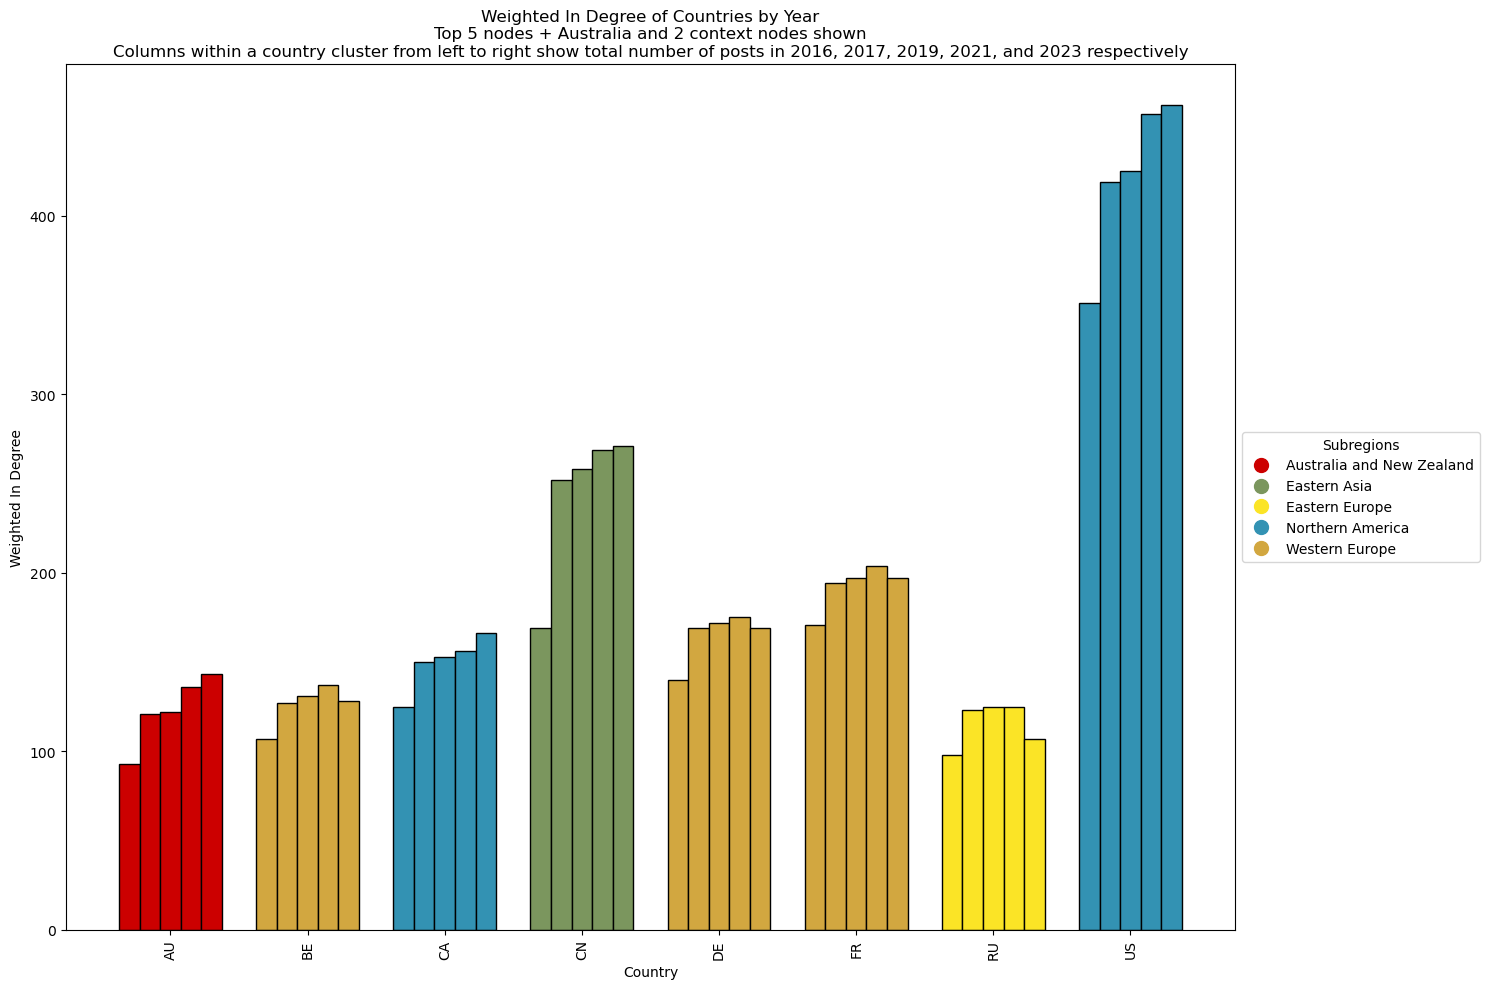

In [10]:
# Function to get nodes with incoming edges and their weighted in-degrees for a given graph
def get_weighted_in_degrees(graph):
    weighted_in_degrees = {node: graph.in_degree(node, weight='weight') for node in graph.nodes if graph.in_degree(node) > 0}
    return weighted_in_degrees

# Initialise a dictionary to store the results
in_degrees_by_year = {}

# Compute the weighted in-degrees for each year
for year, graph in graphs.items():
    in_degrees_by_year[year] = get_weighted_in_degrees(graph)

# Collect data for plotting
data = []
for year, in_degrees in in_degrees_by_year.items():
    for node, in_degree in in_degrees.items():
        subregion = graph.nodes[node]['subregion']
        subregion_colour = graph.nodes[node]['subregionColour']
        data.append([year, node, in_degree, subregion, subregion_colour])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Year', 'Country', 'InDegree', 'Subregion', 'SubregionColour'])

# Identify top 4 countries by in-degree and countries with similar in-degrees to Australia
top_countries = df.groupby('Country')['InDegree'].sum().nlargest(5).index.tolist()
au_in_degrees = df[df['Country'] == 'AU'].groupby('Country')['InDegree'].sum().values[0]

# Find the countries with the most similar in-degrees to Australia
df['InDegreeDiff'] = (df.groupby('Country')['InDegree'].transform('sum') - au_in_degrees).abs()
similar_countries = df.loc[df['Country'] != 'AU'].groupby('Country')['InDegreeDiff'].mean().nsmallest(2).index.tolist()

# Combine the top countries, Australia, and similar countries
selected_countries = top_countries + ['AU'] + similar_countries

# Filter DataFrame for selected countries
df = df[df['Country'].isin(selected_countries)]

# Pivot the DataFrame for plotting
df_pivot = df.pivot_table(index='Country', columns='Year', values='InDegree', fill_value=0)

# Plotting the data
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each year as a separate bar in the clustered column chart
bar_width = 0.15
years = sorted(df['Year'].unique())
positions = range(len(df_pivot.index))
for i, year in enumerate(years):
    year_data = df_pivot[year]
    bar_positions = [p + i * bar_width for p in positions]
    country_colors = [df[df['Country'] == country]['SubregionColour'].values[0] for country in df_pivot.index]
    bars = ax.bar(bar_positions, year_data, width=bar_width, label=year, color=country_colors, edgecolor='black')  # Add edgecolor for border

# Set the position of the x ticks
ax.set_xticks([p + (len(years) - 1) * bar_width / 2 for p in positions])
ax.set_xticklabels(df_pivot.index, rotation=90)

# Adding labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Weighted In Degree')
ax.set_title('Weighted In Degree of Countries by Year\nTop 5 nodes + Australia and 2 context nodes shown\nColumns within a country cluster from left to right show total number of posts in 2016, 2017, 2019, 2021, and 2023 respectively')

# Create a custom legend for subregions
subregions = df[['Subregion', 'SubregionColour']].drop_duplicates().sort_values('Subregion')
handles = [plt.Line2D([0], [0], marker='o', color=row['SubregionColour'], markersize=10, linestyle='') for _, row in subregions.iterrows()]
labels = subregions['Subregion'].tolist()
ax.legend(handles, labels, title='Subregions', loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.tight_layout()
plt.show()

In [11]:
# Grouping by 'COUNTRY' and 'Year'
post_counts_summary = post_counts_df.groupby(['COUNTRY', 'Year'])['POST COUNT'].sum().reset_index()

# Join the aggregated data with the countries data to get the country names
post_counts_summary = post_counts_summary.merge(countries_df[['id', 'name']], left_on='COUNTRY', right_on='id', how='left')

# Now let's find the top 10 countries by post count for each year
top_countries_by_year = post_counts_summary.groupby('Year', group_keys=False).apply(
    lambda x: x.nlargest(10, 'POST COUNT').reset_index(drop=True)
).reset_index(drop=True)

post_counts_summary, top_countries_by_year.head()

C:\Users\khigg\AppData\Local\Temp\ipykernel_24452\1731459389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_countries_by_year = post_counts_summary.groupby('Year', group_keys=False).apply(


(    COUNTRY  Year  POST COUNT  id          name
 0        AR  2016         153  AR     Argentina
 1        AR  2017         155  AR     Argentina
 2        AR  2019         157  AR     Argentina
 3        AR  2021         155  AR     Argentina
 4        AR  2023         150  AR     Argentina
 ..      ...   ...         ...  ..           ...
 289      ZA  2016         124  ZA  South Africa
 290      ZA  2017         123  ZA  South Africa
 291      ZA  2019         124  ZA  South Africa
 292      ZA  2021         125  ZA  South Africa
 293      ZA  2023         114  ZA  South Africa
 
 [294 rows x 5 columns],
   COUNTRY  Year  POST COUNT  id           name
 0      US  2016         271  US  United States
 1      FR  2016         267  FR         France
 2      CN  2016         263  CN          China
 3      RU  2016         244  RU         Russia
 4      TR  2016         225  TR         Turkey)

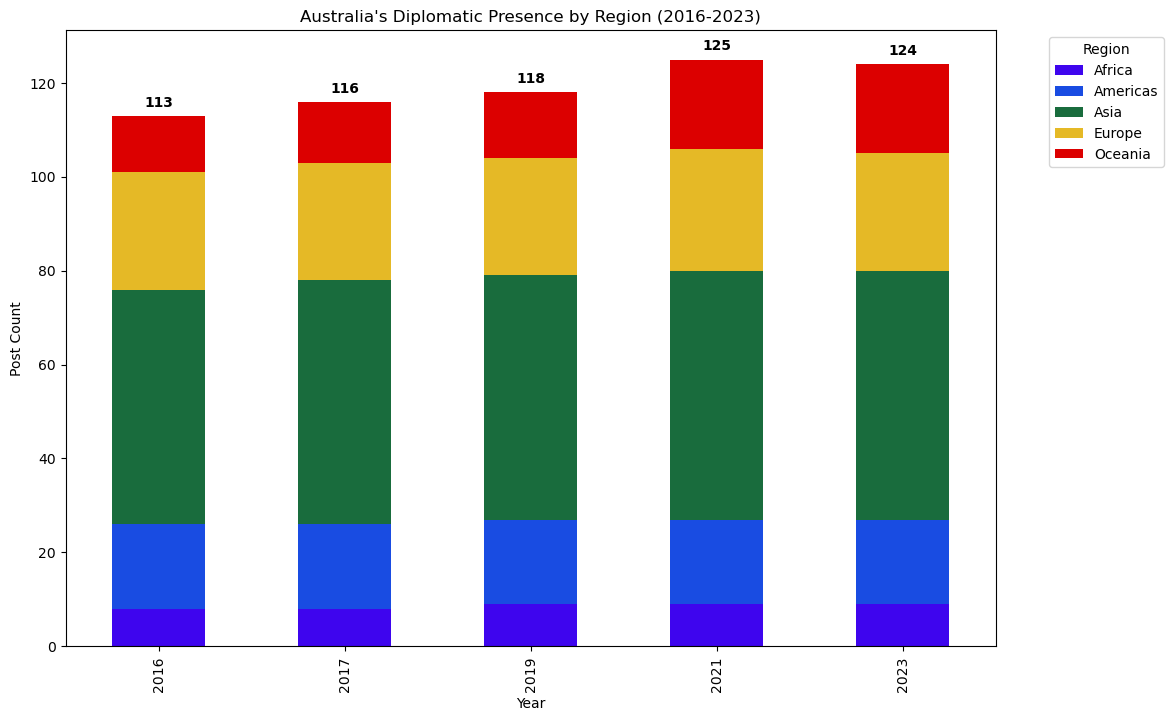

In [12]:
australia_posts = post_counts_df[post_counts_df['COUNTRY'] == 'AU']

australia_posts = australia_posts.merge(countries_df[['id', 'region', 'regionColour']], left_on='POST COUNTRY', right_on='id', how='left')

australia_posts_summary = australia_posts.groupby(['Year', 'region', 'regionColour'])['POST COUNT'].sum().reset_index()

australia_posts_summary

# Pivot the DataFrame to have years as index and regions as columns
pivot_df = australia_posts_summary.pivot(index='Year', columns='region', values='POST COUNT').fillna(0)

# Plotting the bar chart with legend outside and total count on top of each bar
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, ax=ax, color=australia_posts_summary.drop_duplicates('region')['regionColour'])

# Calculating the total post count for each year and placing the label
totals = pivot_df.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 2, str(total), ha='center', weight='bold')

# Setting the title and labels
ax.set_title("Australia's Diplomatic Presence by Region (2016-2023)")
ax.set_xlabel("Year")
ax.set_ylabel("Post Count")

# Moving the legend outside the plot
ax.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#fig.savefig("Australias_Diplomatic_Presence_2016_2023.png", bbox_inches='tight')


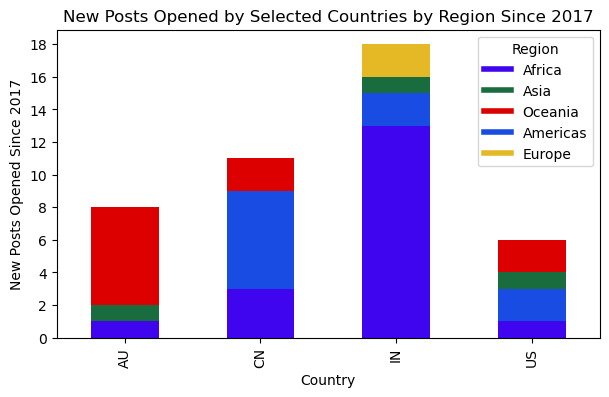

In [13]:
# Filter data for the selected countries
selected_countries_posts = post_counts_df[post_counts_df['COUNTRY'].isin(['AU', 'CN', 'US', 'IN', 'ID'])]

# Create an empty DataFrame to store new posts by year
new_posts_by_year = pd.DataFrame(columns=['COUNTRY', 'POST COUNTRY', 'Year'])

# Determine new posts by year for each country, starting from 2017
for country in ['AU', 'CN', 'US', 'IN', 'ID']:
    country_posts = selected_countries_posts[selected_countries_posts['COUNTRY'] == country]
    for year in sorted(country_posts['Year'].unique()):
        if year == 2016:
            continue  # Skip the year 2016
        current_year_posts = set(country_posts[country_posts['Year'] == year]['POST COUNTRY'])
        previous_year_posts = set(country_posts[country_posts['Year'] < year]['POST COUNTRY'])
        new_posts = current_year_posts - previous_year_posts
        new_posts_by_year = pd.concat(
            [new_posts_by_year, pd.DataFrame({'COUNTRY': country, 'POST COUNTRY': list(new_posts), 'Year': year})],
            ignore_index=True
        )

# Merge the new posts by year with countries to get subregion and subregionColour for POST COUNTRY
new_posts_with_subregion = new_posts_by_year.merge(
    countries_df[['id', 'region', 'regionColour', 'subregion', 'subregionColour']], 
    left_on='POST COUNTRY', 
    right_on='id', 
    how='left'
)

# Drop the 'id' column as it's redundant now
new_posts_with_subregion.drop(columns=['id'], inplace=True)

# Group by country and region and count the number of new posts
grouped_new_posts = new_posts_with_subregion.groupby(['COUNTRY', 'region', 'regionColour']).size().reset_index(name='New Posts Count')

# Pivot the data for plotting
pivot_data_grouped = grouped_new_posts.pivot_table(
    index='COUNTRY',
    columns='region',
    values='New Posts Count',
    fill_value=0
)

# Create a color map for regions
region_colors_map = dict(zip(grouped_new_posts['region'], grouped_new_posts['regionColour']))

# Plot the data
fig, ax = plt.subplots(figsize=(7, 4))
pivot_data_grouped.plot(kind='bar', stacked=True, color=[region_colors_map[region] for region in pivot_data_grouped.columns], ax=ax)

# Set labels and title
ax.set_xlabel('Country')
ax.set_ylabel('New Posts Opened Since 2017')
ax.set_title('New Posts Opened by Selected Countries by Region Since 2017')

# Change y-axis to display whole numbers only
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Create a legend for regions
handles, labels = ax.get_legend_handles_labels()
unique_regions = grouped_new_posts[['region', 'regionColour']].drop_duplicates()
color_patches = [plt.Line2D([0], [0], color=row['regionColour'], lw=4) for _, row in unique_regions.iterrows()]
unique_labels = unique_regions['region'].tolist()
ax.legend(color_patches, unique_labels, title='Region')

plt.show()

In [14]:
## Network Power

# Variables in dataset 

# countryA
# countryB
# btN bilateralTradeNormValue
# btR bilateralTradeRawValue
# fciN foreignCapitalInvestmentNormValue
# fciR foreignCapitalInvestmentRawValue
# osiR onlineSearchInterestRawValue
# mdR migrantDestinationsRawValue
# mdN migrantDestinationsNormValue
# tdR travelDestinationsRawValue
# tdN travelDestinationsNormValue
# fmfR foreignMediaFlowsRawValue
# atN armsTradeNormValue
# atR armsTradeRawValue
# jtN jointTrainingNormValue
# jtR jointTrainingRawValue
# dedN defenceDialoguesNormValue
# dedR defenceDialoguesRawValue
# didN diplomaticDialoguesNormValue
# didN diplomaticDialoguesRawValue

In [15]:
# online search interest

# Filter the network_power_df for non-NaN values in 'onlineSearchInterestRawValue'
onlineSearchInterest = network_power_df.dropna(subset=['onlineSearchInterestRawValue'])

G_osiR = nx.from_pandas_edgelist(
    df=onlineSearchInterest,
    source='countryA',
    target='countryB',
    edge_attr=['onlineSearchInterestRawValue'],
    create_using=nx.DiGraph()
)

# Rename edge attribute 'onlineSearchInterestRawValue' to 'weight'
for u, v, d in G_osiR.edges(data=True):
    d['weight'] = d.pop('onlineSearchInterestRawValue')

# Confirming the update by checking a few edge details
edge_details_updated = list(G_osiR.edges(data=True))[:5]
edge_details_updated

# Correct the index column and add attributes
country_info = countries_df.set_index('id').to_dict('index')

# Filter country_attributes_df for the year 2023
country_attributes_2023 = country_attributes_df[country_attributes_df['Year'] == 2023].set_index('COUNTRY')

# Create a dictionary for country attributes
country_attributes_info = country_attributes_2023[['POPULATION (M)', 'GDP (B, USD)']].to_dict('index')

# Update the graph with the correct attributes
for node in G_osiR.nodes():
    if node in country_info:
        G_osiR.nodes[node]['subregion'] = country_info[node].get('subregion')
        G_osiR.nodes[node]['subregion_color'] = country_info[node].get('subregionColour')
    if node in country_attributes_info:
        G_osiR.nodes[node]['population_2023'] = country_attributes_info[node].get('POPULATION (M)')
        G_osiR.nodes[node]['GDP_2023'] = country_attributes_info[node].get('GDP (B, USD)')

# Check the number of nodes and edges to confirm creation
num_nodes = G_osiR.number_of_nodes()
num_edges = G_osiR.number_of_edges()

# Show a few edge details and node attributes to confirm everything has been added correctly
edge_details = list(G_osiR.edges(data=True))[:5]
node_attributes = {node: G_osiR.nodes[node] for node in list(G_osiR.nodes)[:5]}

# num_nodes, num_edges, edge_details, node_attributes

In [16]:
# Set display options to show the entire DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to fit the content
pd.set_option('display.max_colwidth', None)  # Adjust column width to fit the content

In [17]:
pagerank = nx.pagerank(G_osiR, weight='weight')

# Sort and display the top 5 nodes by PageRank
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
top_6_pagerank = [(node, round(rank, 2)) for node, rank in sorted_pagerank[:6]]

top_6_pagerank

bottom_5_pagerank = [(node, round(rank, 2)) for node, rank in sorted_pagerank[-5:]]

sorted_pagerank

[('JP', 0.1541194921094484),
 ('US', 0.11375317662150906),
 ('CN', 0.10724435439656198),
 ('IN', 0.09396449697743527),
 ('SK', 0.06718038184644991),
 ('AU', 0.05308242927169293),
 ('TH', 0.03989958690025213),
 ('RU', 0.035829904751517413),
 ('SG', 0.03321633904969601),
 ('VN', 0.029661697589070026),
 ('NZ', 0.026287177850123078),
 ('PK', 0.025890451512565547),
 ('PH', 0.024900480122836847),
 ('ID', 0.024104082042803565),
 ('MA', 0.022220530029223938),
 ('TW', 0.021622619487506625),
 ('BA', 0.01915908405209723),
 ('MY', 0.01756467462829505),
 ('NP', 0.017186180133021936),
 ('NK', 0.014624922978226283),
 ('SL', 0.012589242707708729),
 ('CB', 0.011708079119043098),
 ('MO', 0.01123570143128116),
 ('LA', 0.008939914498372411),
 ('BR', 0.0072114663325454),
 ('PG', 0.006803533560716264)]

In [18]:
hubs, authorities = nx.hits(G_osiR)
# Sort and display the top 6 hubs and authorities
sorted_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)
sorted_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)

top_6_hubs = [(node, round(score, 2)) for node, score in sorted_hubs[:6]]
top_6_authorities = [(node, round(score, 2)) for node, score in sorted_authorities[:6]]

sorted_hubs, sorted_authorities

C:\Users\khigg\anaconda3\envs\NetworkScience\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


([('MY', 0.05877412314706989),
  ('TH', 0.05591133323686764),
  ('VN', 0.05430788341370337),
  ('MO', 0.05229496468801093),
  ('PH', 0.050320442265359235),
  ('NP', 0.04550986447848869),
  ('SK', 0.04474828991208618),
  ('SL', 0.04469339996848052),
  ('TW', 0.04376676389571327),
  ('RU', 0.043725119931301626),
  ('CB', 0.04369276142351162),
  ('PK', 0.04237587083264507),
  ('BA', 0.041186869814056344),
  ('MA', 0.039023111390267914),
  ('US', 0.038280840771051414),
  ('LA', 0.03559357372426087),
  ('SG', 0.03305727269593181),
  ('NZ', 0.03299423431697111),
  ('AU', 0.0329712966595284),
  ('IN', 0.032449279136158915),
  ('ID', 0.03033561152278298),
  ('PG', 0.03006625099840545),
  ('BR', 0.02677339668881689),
  ('CN', 0.024060487900405145),
  ('JP', 0.02308695718812486),
  ('NK', -0.0)],
 [('JP', 0.2384958373461349),
  ('IN', 0.13999737554451575),
  ('CN', 0.11919197286555151),
  ('US', 0.1118559204734656),
  ('TH', 0.06190433942765335),
  ('AU', 0.05229199540417406),
  ('SG', 0.0355634

{0: ['AU', 'PG', 'NZ'],
 1: ['NP', 'IN', 'PK', 'SL', 'BA'],
 2: ['BR', 'ID', 'SG', 'MA'],
 3: ['US', 'VN', 'JP', 'PH', 'MY', 'SK', 'TW', 'RU', 'NK', 'MO', 'CN'],
 4: ['CB', 'LA', 'TH']}

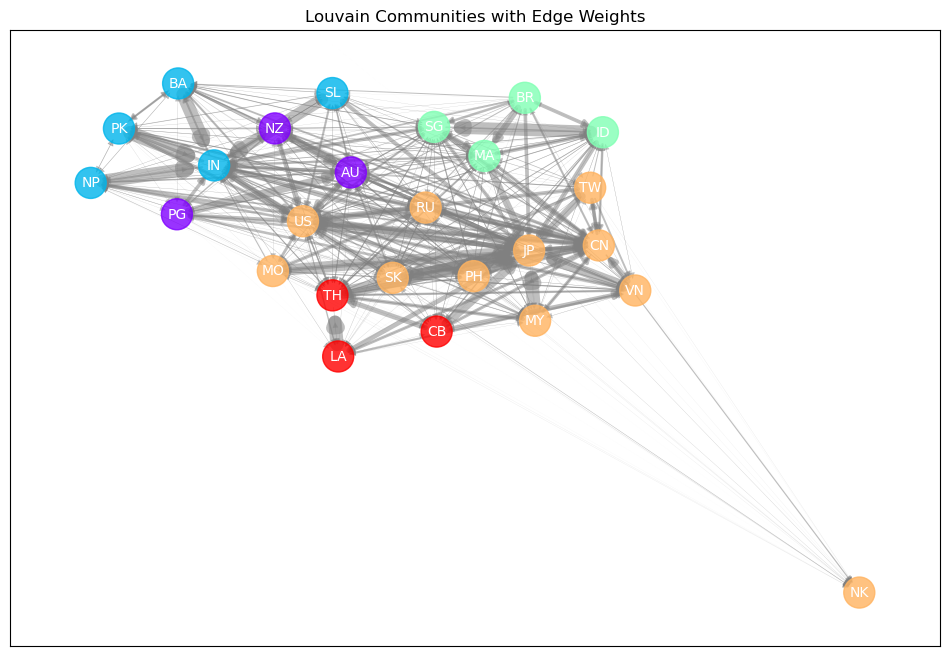

Louvain Communities:
Community 0: ['AU', 'PG', 'NZ']
Community 1: ['NP', 'IN', 'PK', 'SL', 'BA']
Community 2: ['BR', 'ID', 'SG', 'MA']
Community 3: ['US', 'VN', 'JP', 'PH', 'MY', 'SK', 'TW', 'RU', 'NK', 'MO', 'CN']
Community 4: ['CB', 'LA', 'TH']
Modularity: 0.21595920229014495


In [24]:
# Perform Greedy Modularity Maximization community detection
greedy_modularity_communities = nx_comm.greedy_modularity_communities(G_osiR, weight='weight')
gm_communities = [list(community) for community in greedy_modularity_communities]

# Perform Girvan-Newman community detection
girvan_newman_communities = list(nx_comm.girvan_newman(G_osiR))
gn_communities_level_1 = [list(community) for community in girvan_newman_communities[0]]

# Convert communities to dictionaries for easier comparison
gn_communities_dict = {i: community for i, community in enumerate(gn_communities_level_1)}
gm_communities_dict = {i: community for i, community in enumerate(gm_communities)}

gn_communities_dict, gm_communities_dict

({0: ['PG',
   'PH',
   'CB',
   'TW',
   'CN',
   'ID',
   'BA',
   'PK',
   'VN',
   'MA',
   'IN',
   'SK',
   'NP',
   'US',
   'JP',
   'NZ',
   'AU',
   'SL',
   'SG',
   'TH',
   'MO',
   'BR',
   'LA',
   'MY',
   'RU'],
  1: ['NK']},
 {0: ['VN', 'JP', 'LA', 'CB', 'MY', 'SK', 'TW', 'TH', 'NK', 'MO', 'CN'],
  1: ['US', 'AU', 'PG', 'PH', 'RU', 'NZ'],
  2: ['NP', 'IN', 'PK', 'SL', 'BA'],
  3: ['BR', 'ID', 'SG', 'MA']})

In [25]:
G_osiR['AU'].items()
G_osiR.in_edges('AU', data=True)
sorted(G_osiR['AU'].items(), key=lambda x: x[1]['weight'], reverse=True)
sorted(G_osiR.in_edges('AU', data=True), key=lambda x: x[2]['weight'], reverse=True)

[('PG', 'AU', {'weight': 0.2894697977}),
 ('NZ', 'AU', {'weight': 0.2866237631}),
 ('US', 'AU', {'weight': 0.0819672131}),
 ('IN', 'AU', {'weight': 0.0817810892}),
 ('SK', 'AU', {'weight': 0.0701915709}),
 ('SL', 'AU', {'weight': 0.0656634747}),
 ('NP', 'AU', {'weight': 0.0590731625}),
 ('JP', 'AU', {'weight': 0.0484212176}),
 ('CN', 'AU', {'weight': 0.046181771}),
 ('PK', 'AU', {'weight': 0.045176588}),
 ('SG', 'AU', {'weight': 0.0441430333}),
 ('RU', 'AU', {'weight': 0.0425777863}),
 ('PH', 'AU', {'weight': 0.0418154408}),
 ('BA', 'AU', {'weight': 0.0340479193}),
 ('MO', 'AU', {'weight': 0.0329777971}),
 ('TW', 'AU', {'weight': 0.025949103}),
 ('VN', 'AU', {'weight': 0.0241400746}),
 ('BR', 'AU', {'weight': 0.0223330562}),
 ('MA', 'AU', {'weight': 0.0219930146}),
 ('TH', 'AU', {'weight': 0.0172032193}),
 ('CB', 'AU', {'weight': 0.0145108098}),
 ('ID', 'AU', {'weight': 0.0140764695}),
 ('LA', 'AU', {'weight': 0.0108968072}),
 ('MY', 'AU', {'weight': 0.0096485183})]

Top 5 Targets of AU's Searches: [('US', {'weight': 0.2100456621}), ('IN', {'weight': 0.1417315785}), ('NZ', {'weight': 0.1306294207}), ('JP', {'weight': 0.1043065628}), ('CN', {'weight': 0.0962485451})]
Top 5 Sources of Searches to AU: [('PG', 'AU', {'weight': 0.2894697977}), ('NZ', 'AU', {'weight': 0.2866237631}), ('US', 'AU', {'weight': 0.0819672131}), ('IN', 'AU', {'weight': 0.0817810892}), ('SK', 'AU', {'weight': 0.0701915709})]


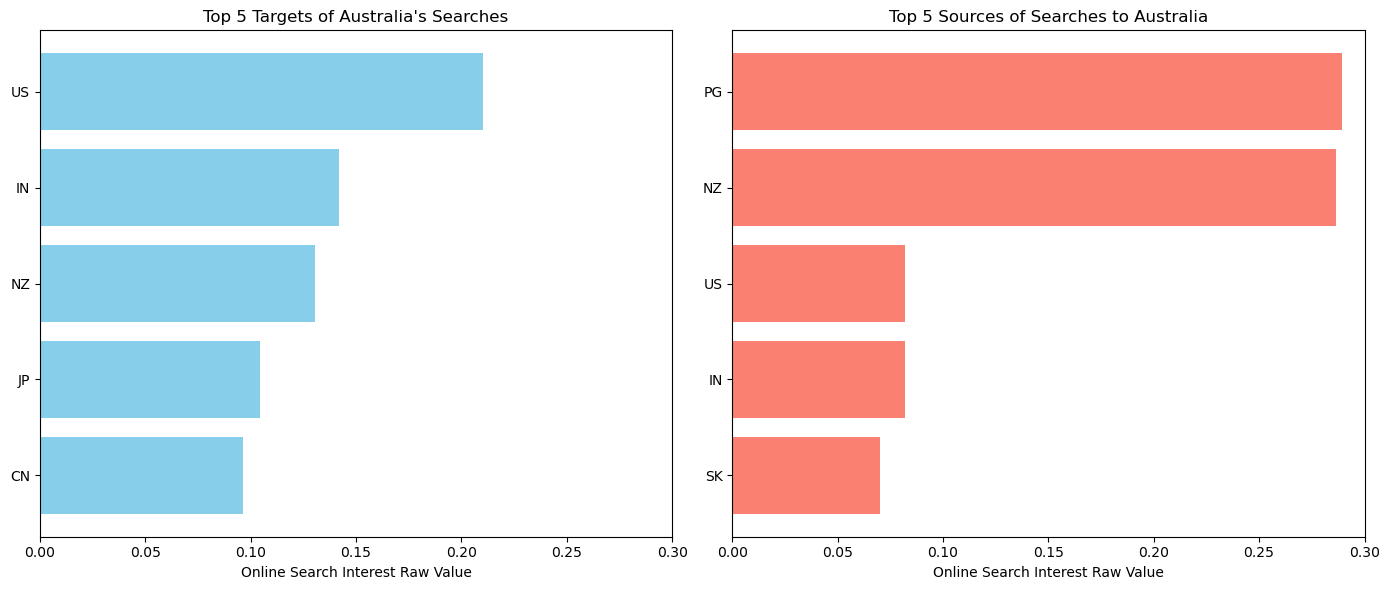

In [26]:
# Get the top 5 targets of Australia's searches
top_5_targets_AU = sorted(G_osiR['AU'].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]

# Get the top 5 sources of searches to Australia
top_5_sources_AU = sorted(G_osiR.in_edges('AU', data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]

print("Top 5 Targets of AU's Searches:", top_5_targets_AU)
print("Top 5 Sources of Searches to AU:", top_5_sources_AU)

# Extract data for visualization
top_5_targets_AU_df = pd.DataFrame(top_5_targets_AU, columns=['Target', 'Data'])
top_5_targets_AU_df['Weight'] = top_5_targets_AU_df['Data'].apply(lambda x: x['weight'])
top_5_targets_AU_df = top_5_targets_AU_df.drop(columns=['Data'])

top_5_sources_AU_df = pd.DataFrame(top_5_sources_AU, columns=['Source', 'Target', 'Data'])
top_5_sources_AU_df['Weight'] = top_5_sources_AU_df['Data'].apply(lambda x: x['weight'])
top_5_sources_AU_df = top_5_sources_AU_df.drop(columns=['Data'])

# Plotting the data
plt.figure(figsize=(14, 6))

# Plot for top 5 targets of Australia
plt.subplot(1, 2, 1)
plt.barh(top_5_targets_AU_df['Target'], top_5_targets_AU_df['Weight'], color='skyblue')
plt.xlabel('Online Search Interest Raw Value')
plt.xlim(0, 0.3)
plt.title('Top 5 Targets of Australia\'s Searches')
plt.gca().invert_yaxis()

# Plot for top 5 sources of searches to Australia
plt.subplot(1, 2, 2)
plt.barh(top_5_sources_AU_df['Source'], top_5_sources_AU_df['Weight'], color='salmon')
plt.xlabel('Online Search Interest Raw Value')
plt.xlim(0, 0.3)
plt.title('Top 5 Sources of Searches to Australia')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

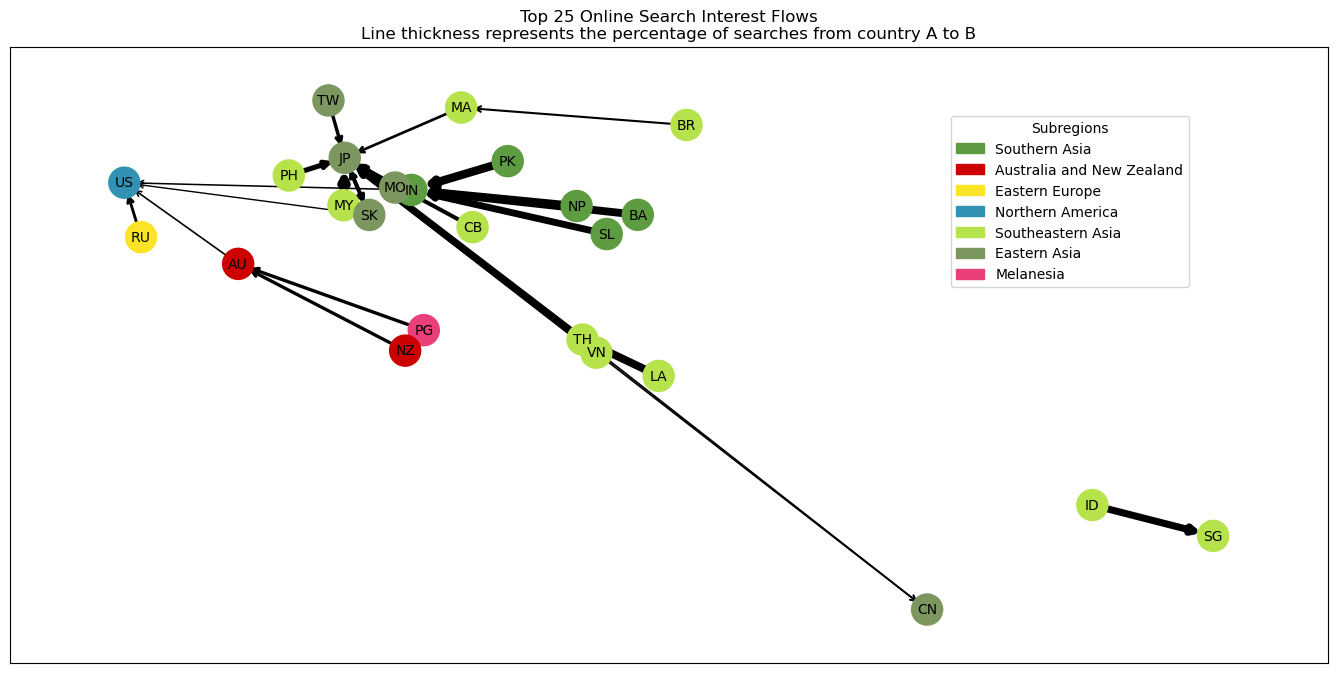

In [27]:
top_edges = sorted(G_osiR.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:25]

subgraph = nx.DiGraph()
for u, v, data in top_edges:
    subgraph.add_edge(u, v, weight=data['weight'])



def update_graph_colors(G, countries_df):
    # Extract nodes data from the graph
    nodes_data = []
    for node, data in G.nodes(data=True):
        nodes_data.append({'node': node, 'label': data.get('label')})
    
    nodes_df = pd.DataFrame(nodes_data)
    
    # Join the nodes_df with countries_df to get the color information using 'id'
    merged_df = nodes_df.merge(countries_df[['id', 'subregionColour']], left_on='node', right_on='id', how='left')
    
    # Update the graph with the color information
    for node in G.nodes:
        node_id = node
        color = merged_df.loc[merged_df['node'] == node_id, 'subregionColour'].values
        G.nodes[node]['color'] = color[0] if len(color) > 0 else '#000000'  # Default to black if no color found

    return G

G_osiR = update_graph_colors(G_osiR, countries_df)

# Extract node colors and edge weights again after merging color information
node_colors = [G_osiR.nodes[node]['color'] for node in subgraph.nodes]
edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges]

# Normalize edge weights for plotting
max_weight = max(edge_weights)
min_weight = min(edge_weights)
edge_thickness = [(weight - min_weight) / (max_weight - min_weight) * 5 + 1 for weight in edge_weights]

# Filter the subregions to only include those relevant to the top 25 edges and nodes
relevant_nodes = set(subgraph.nodes)
relevant_subregions = countries_df[countries_df['id'].isin(relevant_nodes)]['subregion'].unique()

# Create the legend for the relevant subregions
relevant_subregion_colors = countries_df[countries_df['subregion'].isin(relevant_subregions)][['subregion', 'subregionColour']].drop_duplicates()
handles = [mpatches.Patch(color=row['subregionColour'], label=row['subregion']) for idx, row in relevant_subregion_colors.iterrows()]

# Plot the graph with updated colors and arrows for directionality
plt.figure(figsize=(17, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(subgraph, pos, width=edge_thickness, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(subgraph, pos, font_size=10)

# Add a title and subtitle as part of the main title
plt.title('Top 25 Online Search Interest Flows\nLine thickness represents the percentage of searches from country A to B')

# Add the legend for the relevant subregions inside the graph border
plt.legend(handles=handles, title='Subregions', loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.savefig('top_25_online_search_interest_flows.png', format='png', bbox_inches='tight')
plt.show()

In [28]:
## foreign capital investment 

# fciN foreignCapitalInvestmentNormValue
# fciR foreignCapitalInvestmentRawValue

# Filter out rows with 'EU' as either countryA or countryB
filtered_df = network_power_df[(network_power_df['countryA'] != 'EU') & (network_power_df['countryB'] != 'EU')]

# Filter out rows with no value in foreignCapitalInvestmentRawValue column
filtered_df = filtered_df.dropna(subset=['foreignCapitalInvestmentRawValue', 'foreignCapitalInvestmentNormValue'])

# Keep only the necessary columns
filtered_df = filtered_df[['countryA', 'countryB', 'foreignCapitalInvestmentRawValue', 'foreignCapitalInvestmentNormValue']]

# Add back the filter: where countryA should be in countryB column
filtered_df = filtered_df[filtered_df['countryA'].isin(filtered_df['countryB'])]

# Normalize the foreignCapitalInvestmentRawValue
# Sum the raw values for each countryB
raw_value_sum = filtered_df.groupby('countryB')['foreignCapitalInvestmentRawValue'].sum().reset_index()
raw_value_sum.columns = ['countryB', 'sum_raw_value']

# Merge the sums back to the original dataframe
filtered_df = filtered_df.merge(raw_value_sum, on='countryB')

# Normalize the raw values
filtered_df['normalised_raw_value'] = filtered_df['foreignCapitalInvestmentRawValue'] / filtered_df['sum_raw_value']

# Create graph G_fciN using the normalised_raw_value for weights
G_fciN = nx.from_pandas_edgelist(
    df=filtered_df,
    source='countryA',
    target='countryB',
    edge_attr=['normalised_raw_value'],
    create_using=nx.DiGraph()
)

# Rename edge attribute 'normalised_raw_value' to 'weight'
for u, v, d in G_fciN.edges(data=True):
    d['weight'] = d.pop('normalised_raw_value')

# Correct the index column and add attributes
country_info = countries_df.set_index('id').to_dict('index')

# Filter country_attributes_df for the year 2023
country_attributes_2023 = country_attributes_df[country_attributes_df['Year'] == 2023].set_index('COUNTRY')

# Create a dictionary for country attributes
country_attributes_info = country_attributes_2023[['POPULATION (M)', 'GDP (B, USD)']].to_dict('index')

# Update the graph with the correct attributes
for node in G_fciN.nodes():
    if node in country_info:
        G_fciN.nodes[node]['subregion'] = country_info[node].get('subregion')
        G_fciN.nodes[node]['subregion_colour'] = country_info[node].get('subregionColour')
    if node in country_attributes_info:
        G_fciN.nodes[node]['population_2023'] = country_attributes_info[node].get('POPULATION (M)')
        G_fciN.nodes[node]['GDP_2023'] = country_attributes_info[node].get('GDP (B, USD)')

# Check the number of nodes and edges to confirm creation
num_nodes = G_fciN.number_of_nodes()
num_edges = G_fciN.number_of_edges()

# Show a few edge details and node attributes to confirm everything has been added correctly
edge_details = list(G_fciN.edges(data=True))[:5]
node_attributes = {node: G_fciN.nodes[node] for node in list(G_fciN.nodes)}

num_nodes, num_edges, edge_details, node_attributes

(26,
 362,
 [('AU', 'BA', {'weight': 0.008288524066872248}),
  ('AU', 'BR', {'weight': 0.001320802853490291}),
  ('AU', 'CB', {'weight': 0.006756833543662633}),
  ('AU', 'CN', {'weight': 0.024316539304945796}),
  ('AU', 'ID', {'weight': 0.02049699991551869})],
 {'AU': {'subregion': 'Australia and New Zealand',
   'subregion_colour': '#cc0000',
   'population_2023': 26.2,
   'GDP_2023': 1688.0},
  'BA': {'subregion': 'Southern Asia',
   'subregion_colour': '#5d9c41',
   'population_2023': 171.2,
   'GDP_2023': 446.0},
  'BR': {'subregion': 'Southeastern Asia',
   'subregion_colour': '#b6e24b',
   'population_2023': 0.4,
   'GDP_2023': 15.0},
  'CB': {'subregion': 'Southeastern Asia',
   'subregion_colour': '#b6e24b',
   'population_2023': 16.8,
   'GDP_2023': 31.0},
  'CN': {'subregion': 'Eastern Asia',
   'subregion_colour': '#7b965e',
   'population_2023': 1434.1,
   'GDP_2023': 18125.0},
  'ID': {'subregion': 'Southeastern Asia',
   'subregion_colour': '#b6e24b',
   'population_2023'

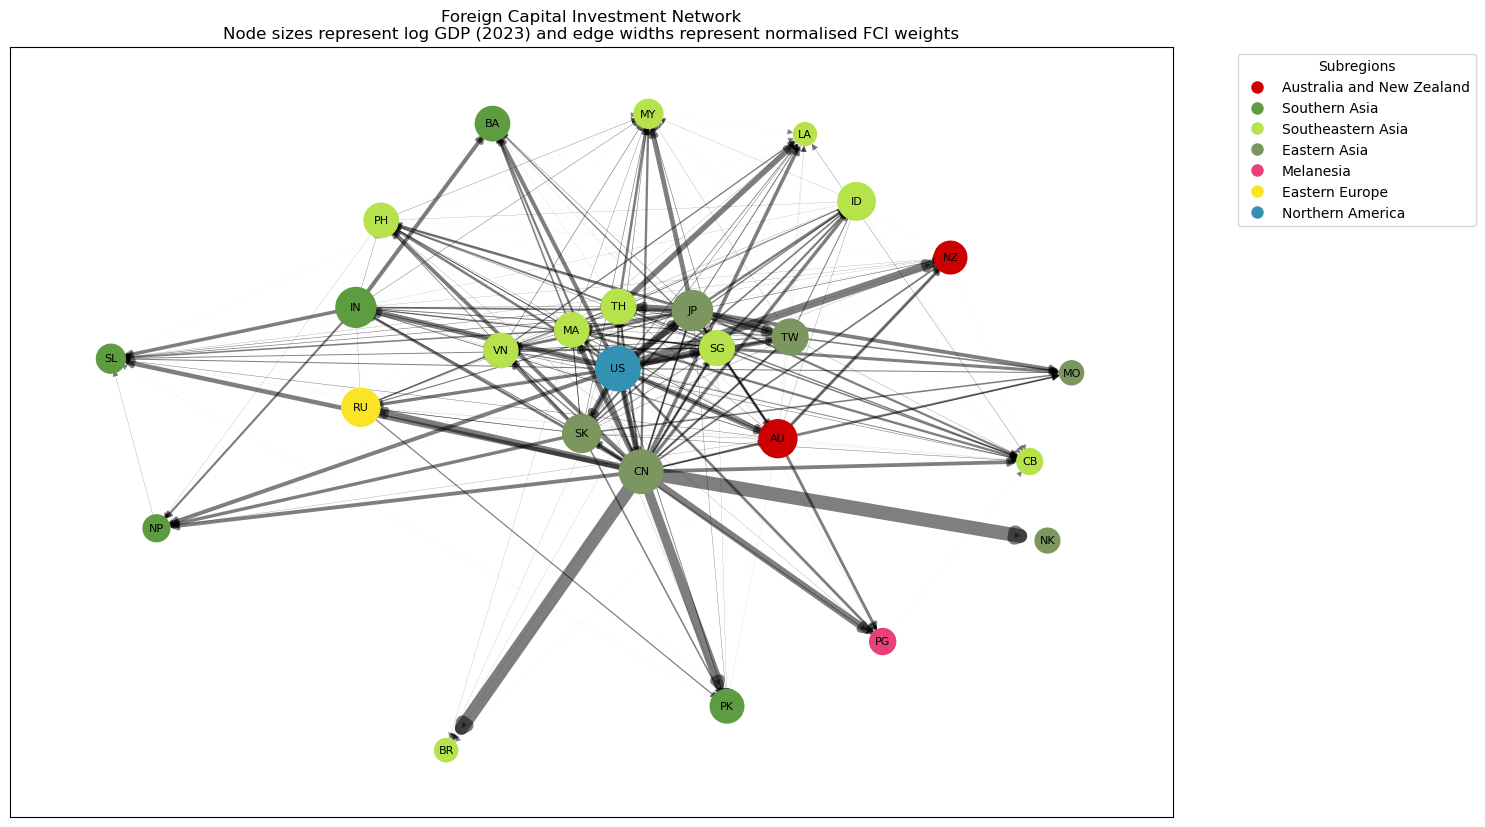

In [67]:
node_size_log = {node: np.log(attr['GDP_2023'] + 1) * 100 for node, attr in G_fciN.nodes(data=True)}

# Generate subregion colors from country_info
subregion_colours = {node: country_info[node]['subregionColour'] for node in G_fciN.nodes}

# Generate edge widths for demonstration
edge_weights = [d['weight'] if 'weight' in d else 1 for _, _, d in G_fciN.edges(data=True)]
max_edge_weight = max(edge_weights)
edge_width = [10 * (weight / max_edge_weight) for weight in edge_weights]

# Draw the graph with improved layout and legend
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_fciN, k=0.5)  # Increase k to separate nodes more

# Draw nodes
nodes = nx.draw_networkx_nodes(G_fciN, pos, node_size=[node_size_log[node] for node in G_fciN.nodes()],
                               node_color=[subregion_colours[node] for node in G_fciN.nodes()])

# Draw edges
nx.draw_networkx_edges(G_fciN, pos, width=edge_width, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G_fciN, pos, font_size=8)

# Create legend for subregions
unique_subregions = {country_info[node]['subregion']: country_info[node]['subregionColour'] for node in G_fciN.nodes}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=subregion) 
                  for subregion, color in unique_subregions.items()]
plt.legend(handles=legend_handles, title="Subregions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Foreign Capital Investment Network')
# Add title and explanation
plt.title('Foreign Capital Investment Network\nNode sizes represent log GDP (2023) and edge widths represent normalised FCI weights')
plt.show()

In [31]:
raw_fci_sum = filtered_df.groupby('countryA')['foreignCapitalInvestmentRawValue'].sum().reset_index()

# Create a bar graph with country on the bottom and raw FCI value on y-axis, colored by subregion
raw_fci_sum = filtered_df.groupby('countryA')['foreignCapitalInvestmentRawValue'].sum().reset_index()
raw_fci_sum = raw_fci_sum.rename(columns={'countryA': 'Country', 'foreignCapitalInvestmentRawValue': 'Total Raw FCI'})
raw_fci_sum = raw_fci_sum.merge(countries_df[['id', 'subregion']], left_on='Country', right_on='id')

raw_fci_sum = raw_fci_sum.drop(columns=['id'])
raw_fci_sum['subregion_color'] = raw_fci_sum['Country'].map(subregion_colours)

raw_fci_sum

,Country,Total Raw FCI,subregion,subregion_color
0,AU,6.075402e+10,Australia and New Zealand,#cc0000
1,BA,1.529560e+09,Southern Asia,#5d9c41
2,BR,1.590000e+08,Southeastern Asia,#b6e24b
3,CB,6.443000e+08,Southeastern Asia,#b6e24b
4,CN,3.670467e+11,Eastern Asia,#7b965e
5,ID,3.894480e+09,Southeastern Asia,#b6e24b
6,IN,4.698605e+10,Southern Asia,#5d9c41
7,JP,3.647619e+11,Eastern Asia,#7b965e
8,LA,3.414000e+08,Southeastern Asia,#b6e24b
9,MA,5.336650e+10,Southeastern Asia,#b6e24b


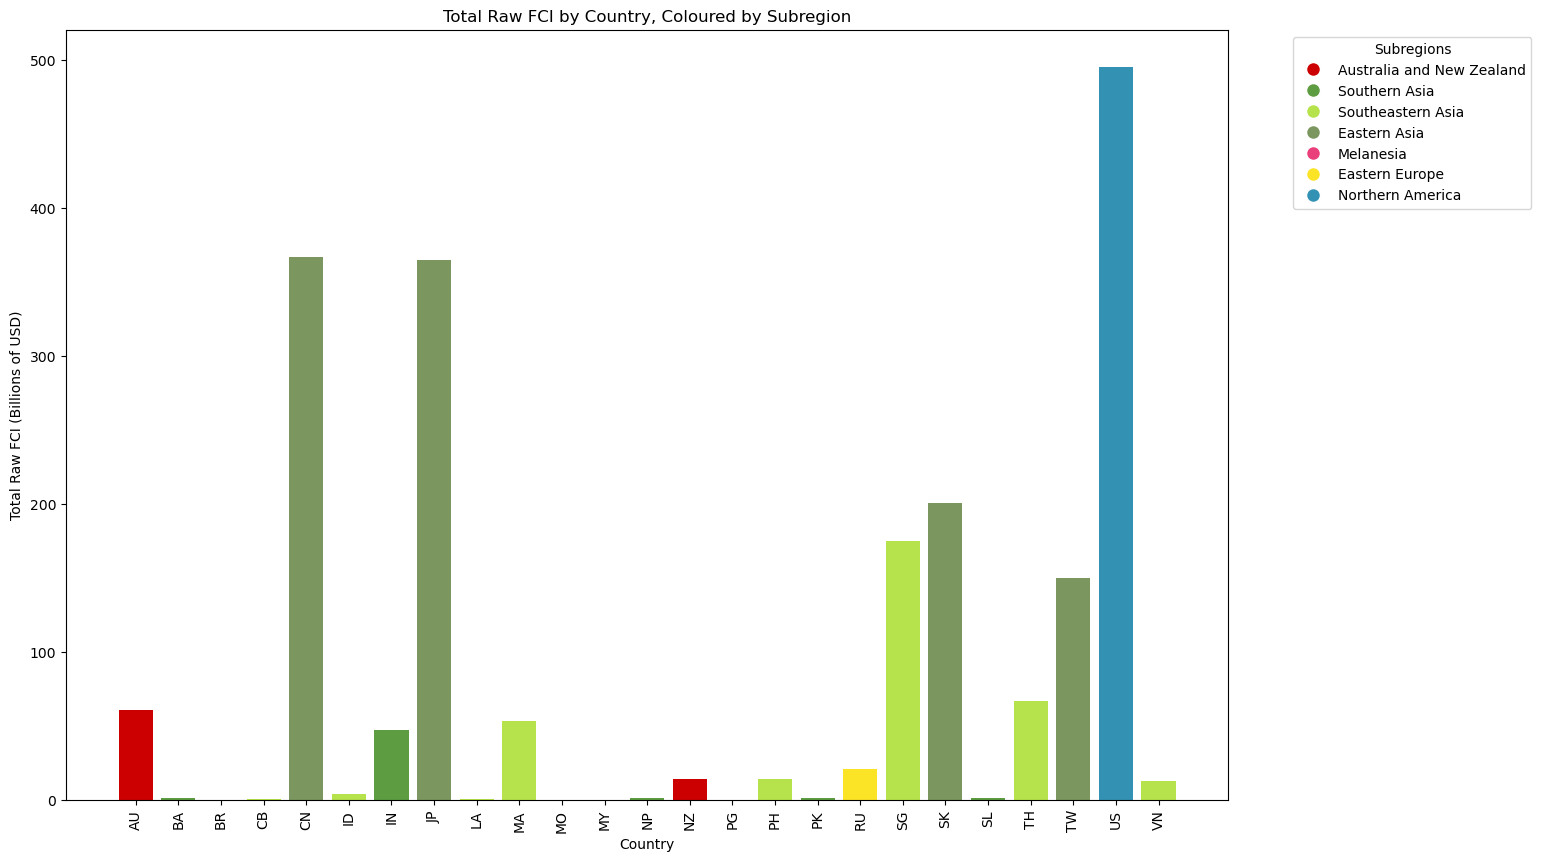

(    Receiving Country Top Sending Country  Percentage Received
 319                AU                  US             0.382781
 320                BA                  US             0.289618
 46                 BR                  CN             0.951353
 47                 CB                  CN             0.270645
 323                CN                  US             0.372402
 48                 ID                  CN             0.235964
 325                IN                  US             0.394642
 326                JP                  US             0.520678
 287                LA                  TH             0.402791
 52                 MA                  CN             0.358137
 115                MO                  JP             0.272899
 116                MY                  JP             0.338748
 55                 NK                  CN             1.000000
 331                NP                  US             0.287661
 332                NZ                  

In [36]:
# Calculate where each country receives the most trade from and gives the most trade to

# Group by countryB to find where each country receives the most trade from
receives_most_trade = filtered_df.loc[filtered_df.groupby('countryB')['normalised_raw_value'].idxmax()]
receives_most_trade = receives_most_trade[['countryB', 'countryA', 'normalised_raw_value']]
receives_most_trade = receives_most_trade.rename(columns={'countryB': 'Receiving Country', 'countryA': 'Top Sending Country', 'normalised_raw_value': 'Percentage Received'})

# Group by countryA to find where each country gives the most trade to
gives_most_trade = filtered_df.loc[filtered_df.groupby('countryA')['normalised_raw_value'].idxmax()]
gives_most_trade = gives_most_trade[['countryA', 'countryB', 'normalised_raw_value']]
gives_most_trade = gives_most_trade.rename(columns={'countryA': 'Sending Country', 'countryB': 'Top Receiving Country', 'normalised_raw_value': 'Percentage Sent'})

raw_fci_sum = filtered_df.groupby('countryA')['foreignCapitalInvestmentRawValue'].sum().reset_index()

# Create a bar graph with country on the bottom and raw FCI value on y-axis, coloured by subregion
raw_fci_sum = filtered_df.groupby('countryA')['foreignCapitalInvestmentRawValue'].sum().reset_index()
raw_fci_sum = raw_fci_sum.rename(columns={'countryA': 'Country', 'foreignCapitalInvestmentRawValue': 'Total Raw FCI'})
raw_fci_sum = raw_fci_sum.merge(countries_df[['id', 'subregion']], left_on='Country', right_on='id')

raw_fci_sum = raw_fci_sum.drop(columns=['id'])
raw_fci_sum['subregion_colour'] = raw_fci_sum['Country'].map(subregion_colours)

# Plot the corrected bar graph with y-axis in billions of USD
plt.figure(figsize=(15, 10))
bars = plt.bar(raw_fci_sum['Country'], raw_fci_sum['Total Raw FCI'] / 1e9, color=raw_fci_sum['subregion_colour'])  # Convert to billions
plt.xlabel('Country')
plt.ylabel('Total Raw FCI (Billions of USD)')
plt.title('Total Raw FCI by Country, Coloured by Subregion')

# Create legend for subregions
legend_handles_corrected = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colour, markersize=10, label=subregion) 
                            for subregion, colour in raw_fci_sum[['subregion', 'subregion_colour']].drop_duplicates().values]
plt.legend(handles=legend_handles_corrected, title="Subregions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

receives_most_trade, gives_most_trade

In [38]:
pagerank = nx.pagerank(G_fciN, weight='weight')

# Sort and display the top 5 nodes by PageRank
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
top_6_pagerank = [(node, round(rank, 2)) for node, rank in sorted_pagerank[:6]]


top_6_pagerank

bottom_5_pagerank = [(node, round(rank, 2)) for node, rank in sorted_pagerank[-5:]]

sorted_pagerank

[('TH', 0.12270130156320815),
 ('LA', 0.11050607001286974),
 ('MY', 0.062364992368075314),
 ('CB', 0.058237664758859296),
 ('SL', 0.05758329401677341),
 ('IN', 0.0511434712036235),
 ('CN', 0.04490011477719618),
 ('SG', 0.042926678560072956),
 ('AU', 0.04052273550689094),
 ('BA', 0.034463124423883475),
 ('MA', 0.033373795922842814),
 ('VN', 0.032122586580159776),
 ('PH', 0.02882799051867951),
 ('RU', 0.027508029879278462),
 ('US', 0.027437225394032014),
 ('JP', 0.027008951440670677),
 ('ID', 0.02697970160558111),
 ('NP', 0.026909448327238746),
 ('PK', 0.022971722813098932),
 ('MO', 0.02061260506038507),
 ('SK', 0.020573383024858897),
 ('NZ', 0.02024417336137604),
 ('PG', 0.020214385804392342),
 ('TW', 0.014990098373258563),
 ('BR', 0.013684338281056453),
 ('NK', 0.011192116421637921)]

In [39]:
hubs, authorities = nx.hits(G_fciN)
# Sort and display the top 6 hubs and authorities
sorted_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)
sorted_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)

top_6_hubs = [(node, round(score, 2)) for node, score in sorted_hubs[:6]]
top_6_authorities = [(node, round(score, 2)) for node, score in sorted_authorities[:6]]

top_6_hubs, top_6_authorities

C:\Users\khigg\anaconda3\envs\NetworkScience\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


([('CN', 0.38),
  ('US', 0.2),
  ('JP', 0.12),
  ('SK', 0.05),
  ('SG', 0.05),
  ('AU', 0.04)],
 [('NK', 0.08),
  ('BR', 0.08),
  ('PK', 0.06),
  ('RU', 0.05),
  ('PG', 0.05),
  ('SK', 0.04)])

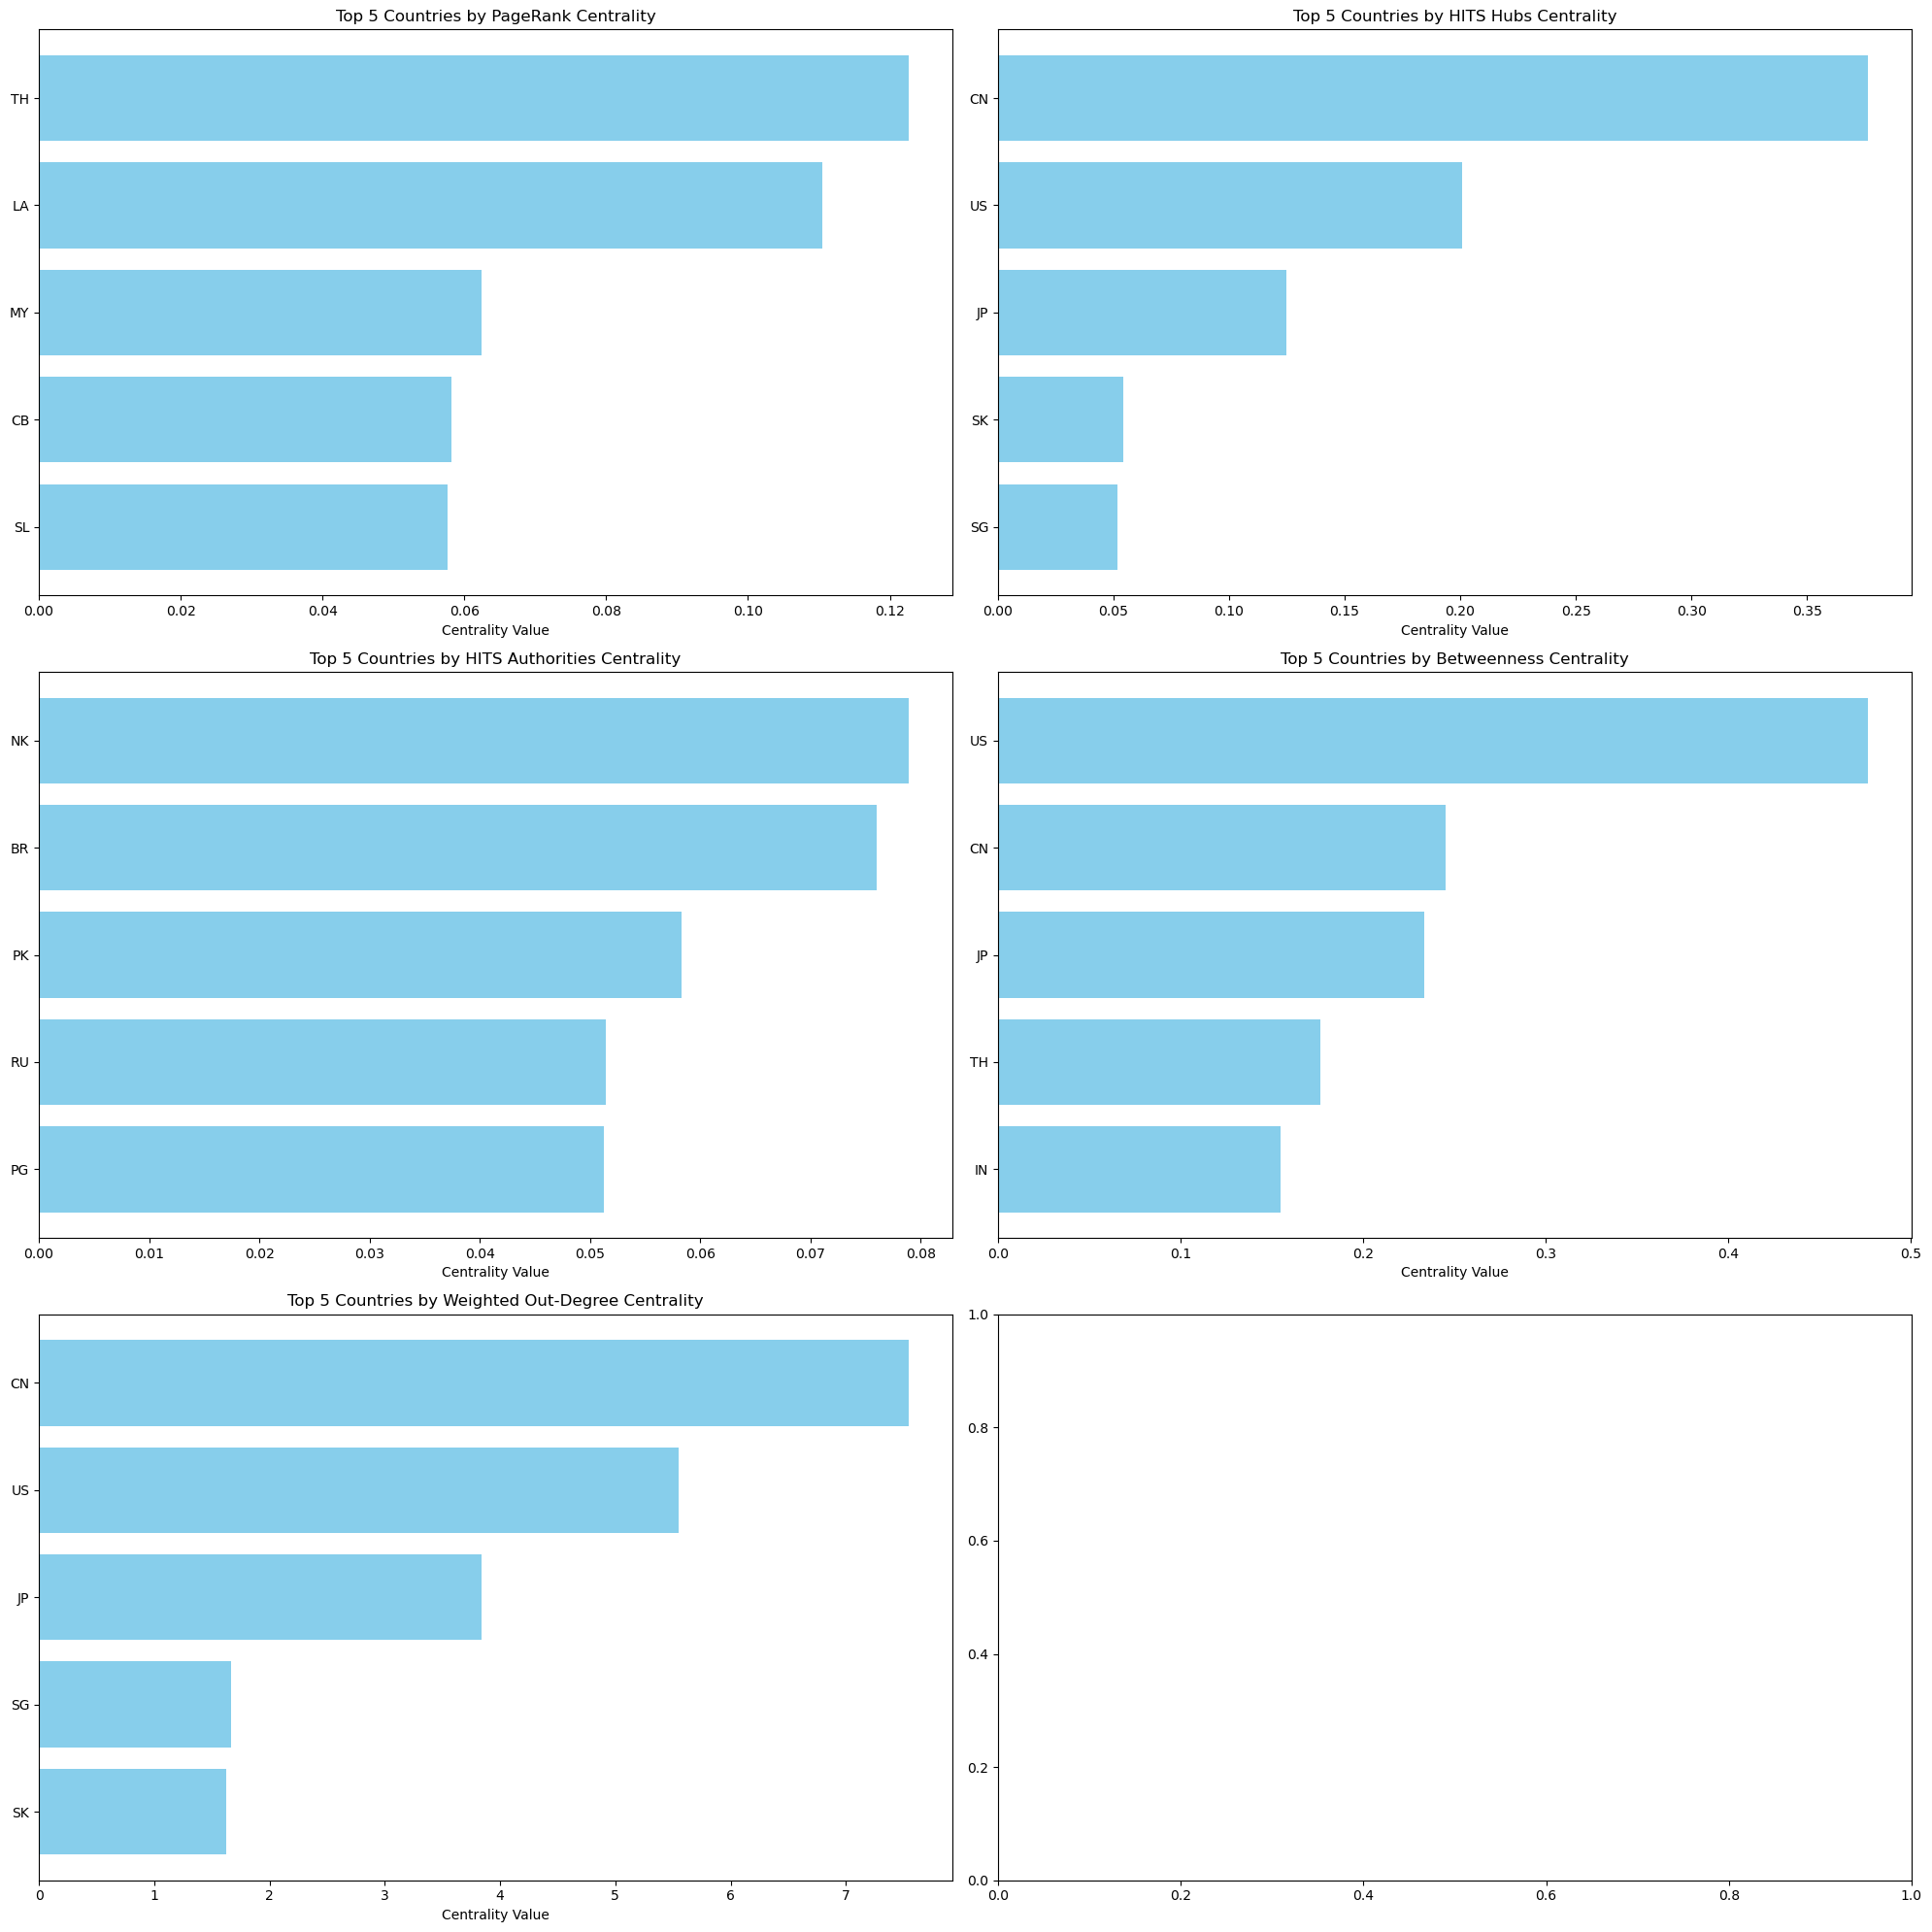

In [41]:

G_fciN_transformed = invert_weights(G_fciN)

# Ocentrality measures as needed
pagerank = nx.pagerank(G_fciN, weight='weight')
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

hits_hubs, hits_authorities = nx.hits(G_fciN)
top_hits_hubs = sorted(hits_hubs.items(), key=lambda x: x[1], reverse=True)[:5]
top_hits_authorities = sorted(hits_authorities.items(), key=lambda x: x[1], reverse=True)[:5]

betweenness_centrality = nx.betweenness_centrality(G_fciN_transformed, weight='transformed_weight')
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

out_degree_centrality = dict(G_fciN.out_degree(weight='weight'))
top_out_degree_centrality = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

(top_pagerank, top_hits_hubs, top_hits_authorities, top_betweenness_centrality, top_out_degree_centrality)

# Prepare data for visualization
centrality_measures = {
    'PageRank': top_pagerank,
    'HITS Hubs': top_hits_hubs,
    'HITS Authorities': top_hits_authorities,
    'Betweenness': top_betweenness_centrality,
    'Weighted Out-Degree': top_out_degree_centrality
}

# Plot each centrality measure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
axes = axes.flatten()

for idx, (measure, data) in enumerate(centrality_measures.items()):
    countries, values = zip(*data)
    axes[idx].barh(countries, values, color='skyblue')
    axes[idx].set_title(f'Top 5 Countries by {measure} Centrality')
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Centrality Value')

plt.tight_layout()
plt.show()

In [42]:
# Filter the network_power_df for non-NaN and non-zero values in 'diplomaticDialoguesRawValue'
diplomatic_dialogues = network_power_df.dropna(subset=['diplomaticDialoguesRawValue'])
diplomatic_dialogues = diplomatic_dialogues[diplomatic_dialogues['diplomaticDialoguesRawValue'] > 0]

# Create an undirected graph for diplomatic dialogues
G_didN = nx.from_pandas_edgelist(
    df=diplomatic_dialogues,
    source='countryA',
    target='countryB',
    edge_attr=['diplomaticDialoguesRawValue'],
    create_using=nx.Graph()
)

# Rename edge attribute 'diplomaticDialoguesRawValue' to 'weight'
for u, v, d in G_didN.edges(data=True):
    d['weight'] = d.pop('diplomaticDialoguesRawValue')

# Add node attributes for regions
for node in G_didN.nodes():
    if node in countries_df['id'].values:
        node_data = countries_df[countries_df['id'] == node].iloc[0]
        G_didN.nodes[node]['region'] = node_data['region']
        G_didN.nodes[node]['region_colour'] = node_data['regionColour']
        G_didN.nodes[node]['subregion'] = node_data['subregion']
        G_didN.nodes[node]['subregion_colour'] = node_data['subregionColour']

# Compute centrality measures for the new graph G_didN

# Calculate PageRank
pagerank = nx.pagerank(G_didN, weight='weight')
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

# Calculate HITS (hubs and authorities) without weights
hits_hubs, hits_authorities = nx.hits(G_didN)
top_hits_hubs = sorted(hits_hubs.items(), key=lambda x: x[1], reverse=True)[:5]
top_hits_authorities = sorted(hits_authorities.items(), key=lambda x: x[1], reverse=True)[:5]

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_didN, weight='weight')
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Calculate Closeness Centrality with weights
closeness_centrality = nx.closeness_centrality(G_didN, distance='weight')
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Calculate Degree Centrality
degree = nx.degree(G_didN)
top_degree = sorted(degree, key=lambda x: x[1], reverse=True)[:5]

(top_pagerank, top_hits_hubs, top_hits_authorities, top_betweenness_centrality, top_closeness_centrality, top_degree)

C:\Users\khigg\anaconda3\envs\NetworkScience\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


([('CN', 0.09738111293636326),
  ('US', 0.07899367829033627),
  ('AU', 0.07522430951216735),
  ('ID', 0.06257830210433403),
  ('SK', 0.05985312917156293)],
 [('US', 0.1035562376612992),
  ('CN', 0.08395943232312471),
  ('JP', 0.08151473754966002),
  ('AU', 0.08080801392242692),
  ('SK', 0.07727384741405997)],
 [('US', 0.1035562376612992),
  ('CN', 0.08395943232312468),
  ('JP', 0.08151473754965993),
  ('AU', 0.08080801392242687),
  ('SK', 0.07727384741405997)],
 [('ID', 0.13557754279098153),
  ('TH', 0.10000427767226185),
  ('CN', 0.09577765229939143),
  ('CB', 0.0944856526872337),
  ('SK', 0.08867657375562515)],
 [('ID', 0.5897435897435898),
  ('TH', 0.575),
  ('SK', 0.5609756097560976),
  ('BR', 0.5227272727272727),
  ('JP', 0.5111111111111111)],
 [('ID', 17), ('CN', 17), ('SK', 14), ('US', 14), ('AU', 13)])

In [43]:
# Check the number of nodes and edges to confirm creation
num_nodes = G_didN.number_of_nodes()
num_edges = G_didN.number_of_edges()

# Show a few edge details and node attributes to confirm everything has been added correctly
edge_details = list(G_didN.edges(data=True))[:5]
node_attributes = {node: G_didN.nodes[node] for node in list(G_didN.nodes)[:5]}

num_nodes, num_edges, edge_details, node_attributes

# node_names = set(G_didN.nodes)
# node_names2 = set(G_osiR.nodes)
# node_names2 - node_names

(24,
 112,
 [('AU', 'CB', {'weight': 1.0}),
  ('AU', 'ID', {'weight': 2.0}),
  ('AU', 'IN', {'weight': 1.0}),
  ('AU', 'JP', {'weight': 6.0}),
  ('AU', 'MA', {'weight': 2.0})],
 {'AU': {'region': 'Oceania',
   'region_colour': '#dc0000',
   'subregion': 'Australia and New Zealand',
   'subregion_colour': '#cc0000'},
  'CB': {'region': 'Asia',
   'region_colour': '#196c3d',
   'subregion': 'Southeastern Asia',
   'subregion_colour': '#b6e24b'},
  'ID': {'region': 'Asia',
   'region_colour': '#196c3d',
   'subregion': 'Southeastern Asia',
   'subregion_colour': '#b6e24b'},
  'IN': {'region': 'Asia',
   'region_colour': '#196c3d',
   'subregion': 'Southern Asia',
   'subregion_colour': '#5d9c41'},
  'JP': {'region': 'Asia',
   'region_colour': '#196c3d',
   'subregion': 'Eastern Asia',
   'subregion_colour': '#7b965e'}})

In [72]:

degree_dict = dict(nx.degree(G_didN))
#degree_dict = dict(G_didN.degree(weight='weight'))

# Convert the dictionary to a list of tuples and sort by degree
sorted_degree_list = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

print(sorted_degree_list)

[('ID', 17), ('CN', 17), ('SK', 14), ('US', 14), ('AU', 13), ('VN', 13), ('RU', 13), ('IN', 12), ('SG', 11), ('TH', 11), ('CB', 10), ('JP', 10), ('MA', 9), ('SL', 7), ('BR', 7), ('MO', 7), ('PK', 7), ('NZ', 6), ('BA', 6), ('LA', 6), ('PH', 5), ('NP', 4), ('MY', 3), ('PG', 2)]


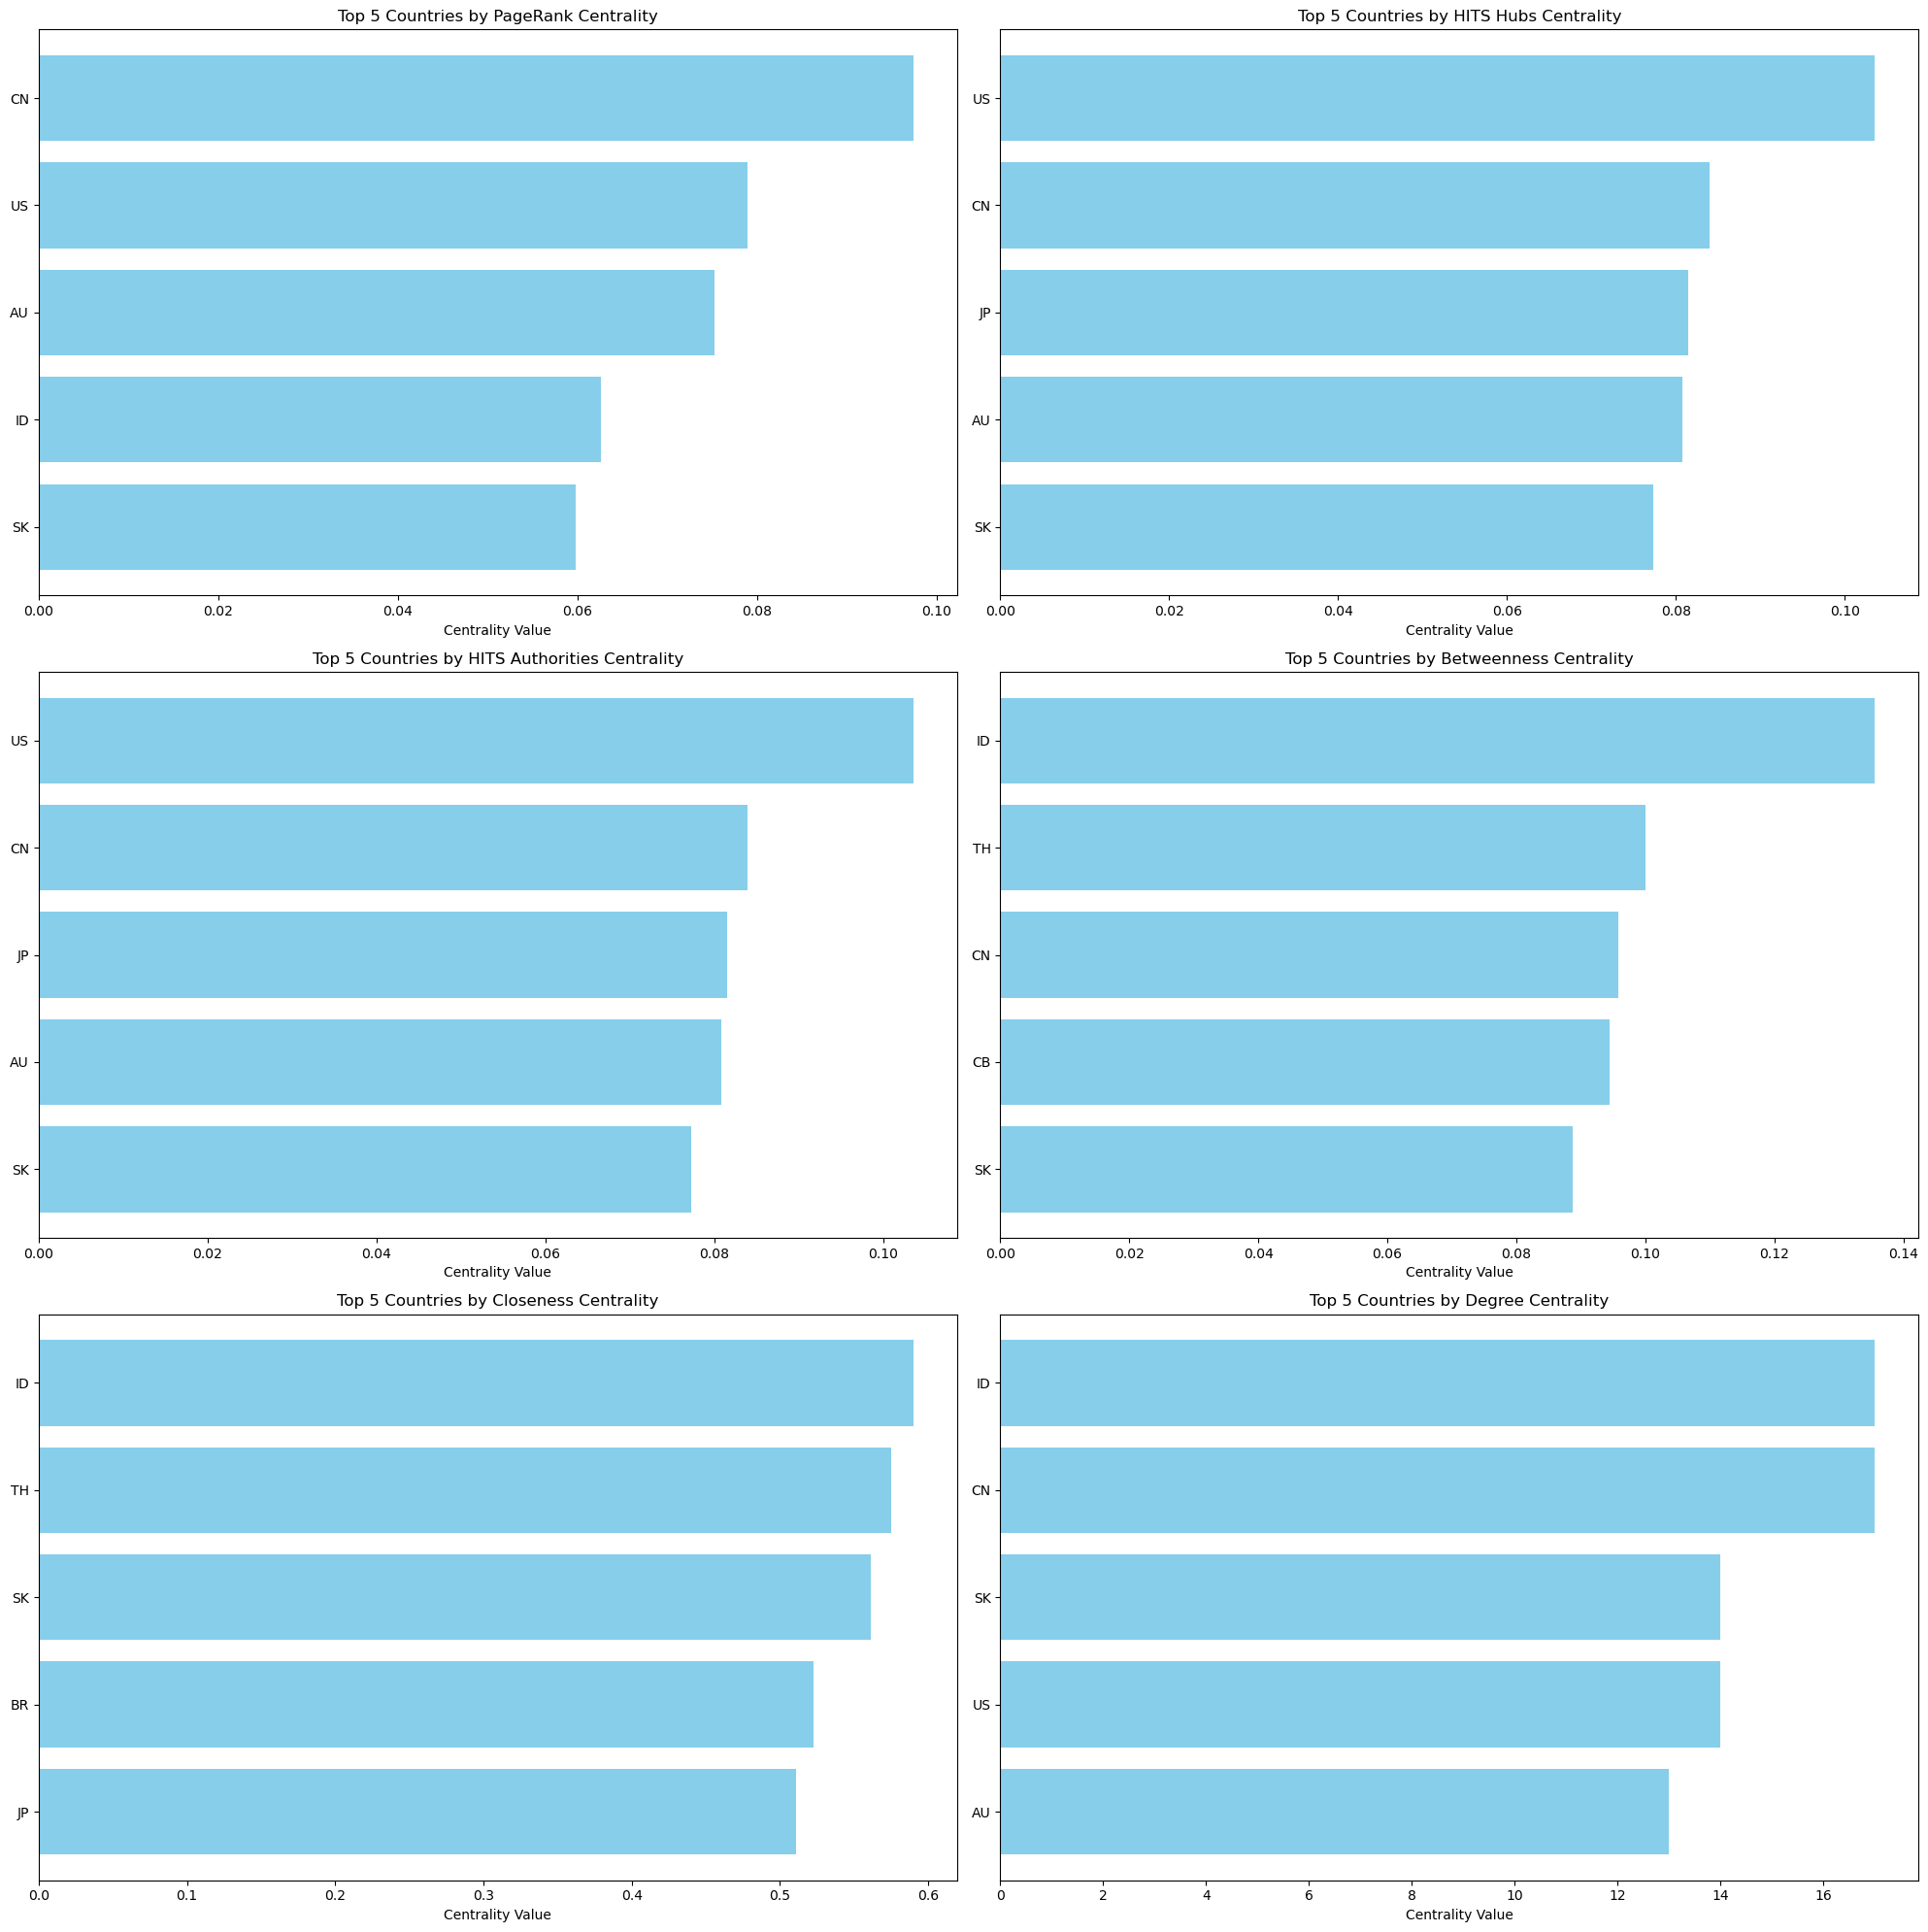

In [45]:
# Prepare data for visualization
centrality_measures = {
    'PageRank': top_pagerank,
    'HITS Hubs': top_hits_hubs,
    'HITS Authorities': top_hits_authorities,
    'Betweenness': top_betweenness_centrality,
    'Closeness': top_closeness_centrality,
    'Degree': top_degree
}

# Plot each centrality measure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
axes = axes.flatten()

for idx, (measure, data) in enumerate(centrality_measures.items()):
    countries, values = zip(*data)
    axes[idx].barh(countries, values, color='skyblue')
    axes[idx].set_title(f'Top 5 Countries by {measure} Centrality')
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Centrality Value')

plt.tight_layout()
plt.show()

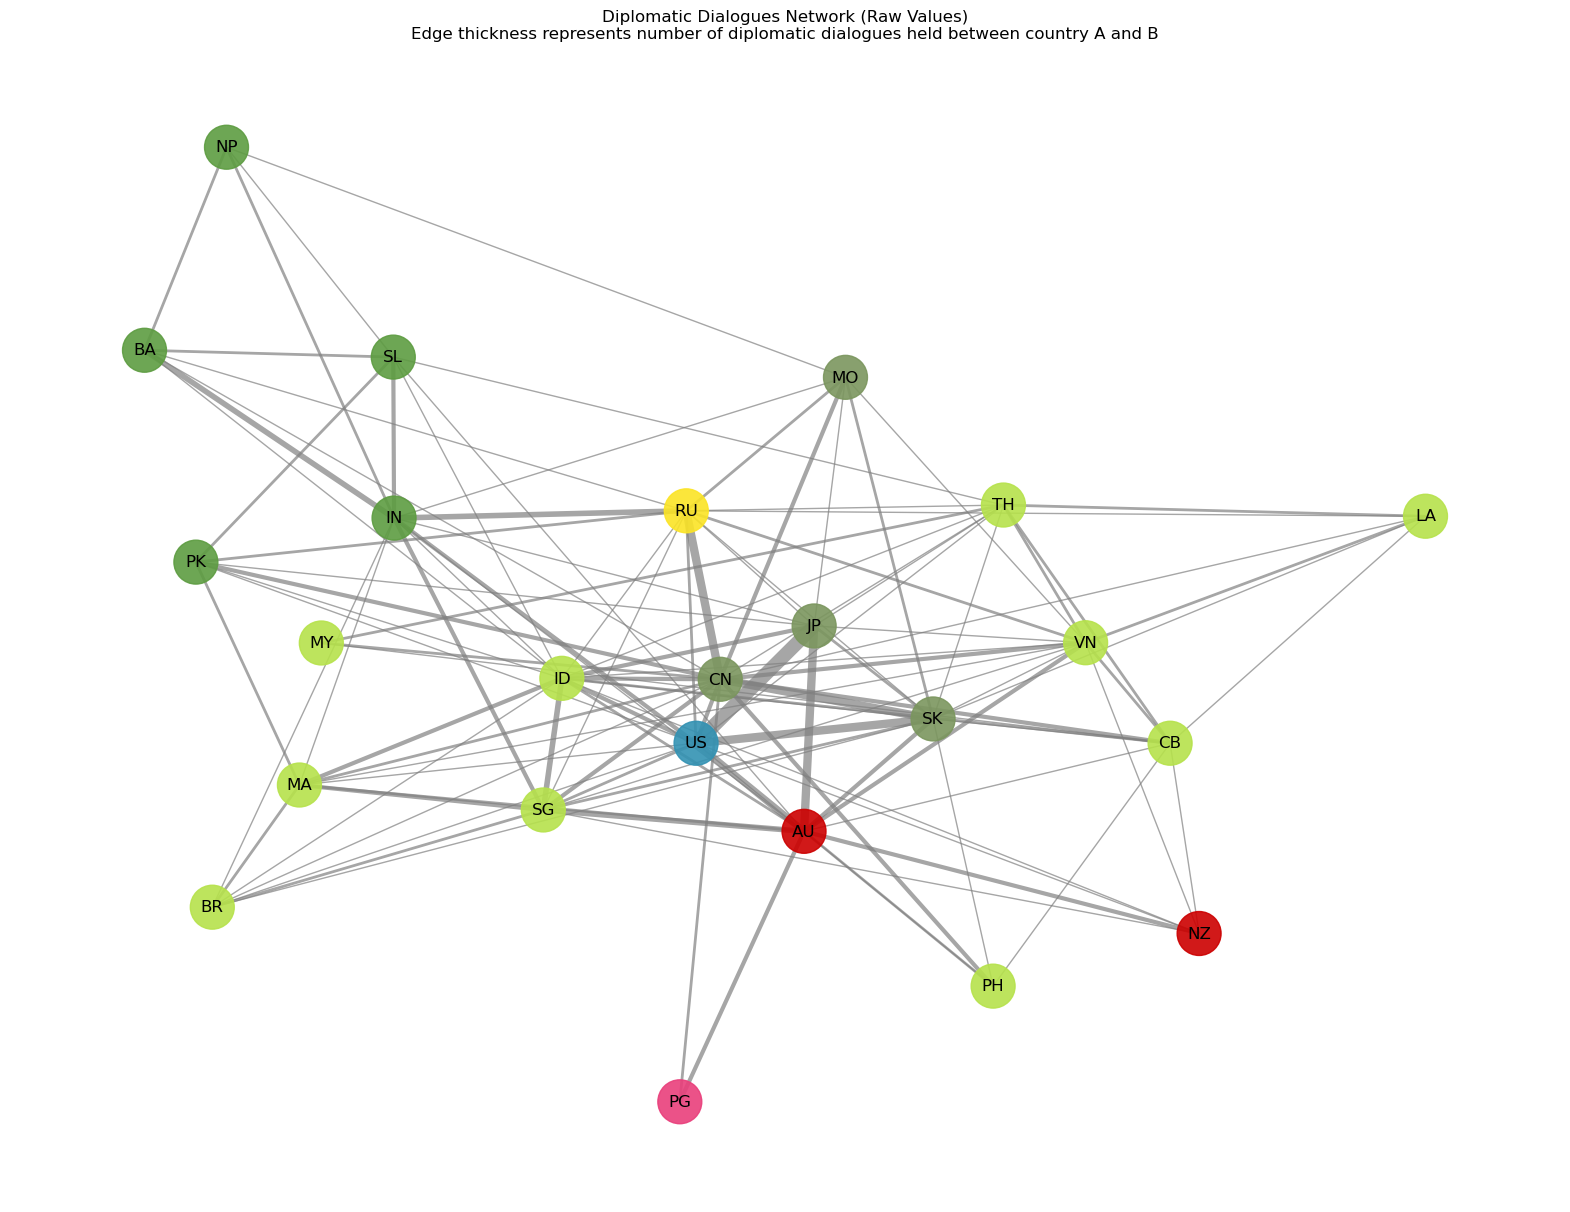

In [61]:
# Calculate weighted degree (this might not be needed if nodes are the same size)
weighted_degree = dict(G_didN.degree(weight='weight'))

# Define edge widths based on weights
edge_widths = [d['weight'] for (u, v, d) in G_didN.edges(data=True)]

# Define node colors based on region
node_colours = [G_didN.nodes[node]['subregion_colour'] for node in G_didN.nodes()]

# Create a layout for the graph
pos = nx.spring_layout(G_didN, seed=42)

# Plot the graph
plt.figure(figsize=(20, 15))
nx.draw_networkx_nodes(G_didN, pos, node_color=node_colours, node_size=1000, alpha=0.9)  # Adjust node_size as needed
nx.draw_networkx_edges(G_didN, pos, width=edge_widths, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G_didN, pos, font_size=12, font_color='black')


plt.title('Diplomatic Dialogues Network (Raw Values)\nEdge thickness represents number of diplomatic dialogues held between country A and B')
plt.axis('off')
plt.show()

Modularity: 0.234


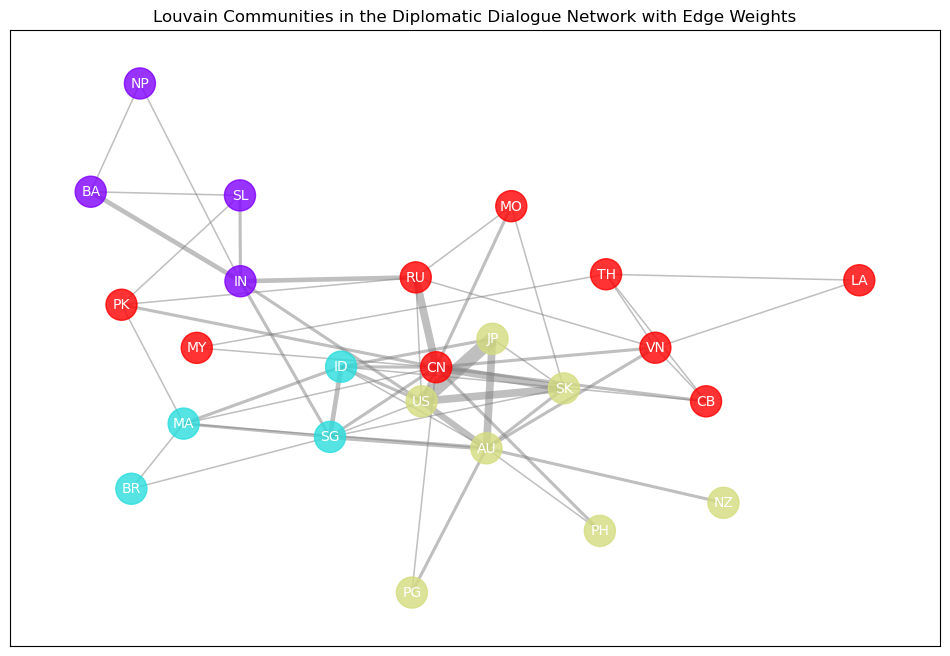

{0: ['SL', 'IN', 'BA', 'NP'],
 1: ['BR', 'ID', 'SG', 'MA'],
 2: ['US', 'AU', 'SK', 'PG', 'JP', 'NZ', 'PH'],
 3: ['PK', 'VN', 'CB', 'LA', 'MY', 'TH', 'RU', 'MO', 'CN']}

In [95]:
# Community partition 

# Perform Louvain community detection on diplomatic dialogue netowrk
louvain_partition_didN = nx_comm.louvain_communities(G_didN, weight='weight', resolution=1, threshold=1e-07)

# Convert partition to a dictionary for easier interpretation
louvain_communities_didN = {i: list(community) for i, community in enumerate(louvain_partition_didN)}

# Display the resulting communities
louvain_communities_didN

# Calculate Modularity
modularity_score_didN = nx_comm.modularity(G_didN, louvain_partition_didN, weight='weight')
print(f"Modularity: {modularity_score_didN:.3f}")

# Normalise edge weights
max_weight_didN = max(nx.get_edge_attributes(G_didN, 'weight').values())
min_weight_didN = min(nx.get_edge_attributes(G_didN, 'weight').values())
norm_edge_weights_didN = [(d['weight'] - min_weight_didN) / (max_weight_didN - min_weight_didN) for _, _, d in G_didN.edges(data=True)]

num_communities_didN = len(louvain_communities_didN)
colours_didN = cm.rainbow(np.linspace(0, 1, num_communities_didN))
colour_map_didN = {i: colours_didN[i] for i in louvain_communities_didN.keys()}

# Nosw colour assignment based on louvain_communities dictionary
node_community_map_didN = {node: community for community, nodes in louvain_communities_didN.items() for node in nodes}
node_colours_didN = [colour_map_didN[node_community_map_didN[node]] for node in G_didN.nodes]

# Draw the graph with community colouring
pos = nx.spring_layout(G_didN, seed=42)
plt.figure(figsize=(12, 8))

# Draw nodes with community colours
nx.draw_networkx_nodes(G_didN, pos, node_size=500, node_color=node_colours_didN, alpha=0.8)
nx.draw_networkx_labels(G_didN, pos, font_size=10, font_color='white')

# Draw edges with normalised weights
nx.draw_networkx_edges(G_didN, pos, width=[w * 10 for w in norm_edge_weights_didN], alpha=0.5, edge_color='gray')

plt.title("Louvain Communities in the Diplomatic Dialogue Network with Edge Weights")
plt.show()
louvain_communities_didN

Modularity: 0.216


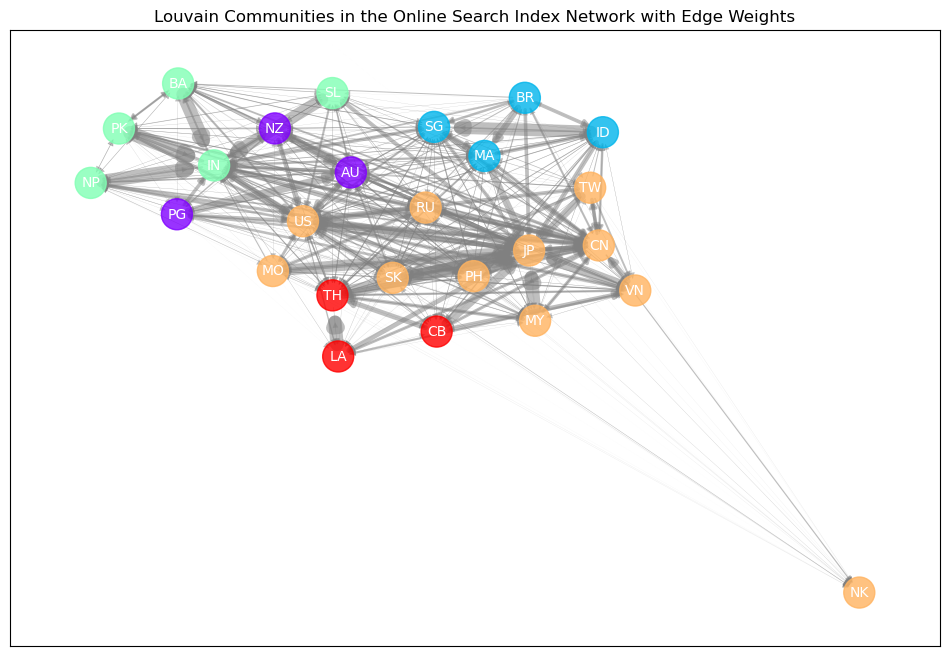

{0: ['AU', 'PG', 'NZ'],
 1: ['BR', 'ID', 'SG', 'MA'],
 2: ['NP', 'SL', 'IN', 'PK', 'BA'],
 3: ['US', 'NK', 'VN', 'JP', 'PH', 'MY', 'SK', 'TW', 'RU', 'MO', 'CN'],
 4: ['CB', 'LA', 'TH']}

In [96]:
# Perform Louvain community detection on online search interest netowrk

louvain_partition_osiR = nx_comm.louvain_communities(G_osiR, weight='weight', resolution=1, threshold=1e-07)

# Convert partition to a dictionary for easier interpretation
louvain_communities_osiR = {i: list(community) for i, community in enumerate(louvain_partition_osiR)}

# Display the resulting communities
louvain_communities_osiR

# Calculate Modularity
modularity_score_osiR = nx_comm.modularity(G_osiR, louvain_partition_osiR, weight='weight')
print(f"Modularity: {modularity_score_osiR:.3f}")

# Normalize edge weights
max_weight_osiR = max(nx.get_edge_attributes(G_osiR, 'weight').values())
min_weight_osiR = min(nx.get_edge_attributes(G_osiR, 'weight').values())
norm_edge_weights_osiR = [(d['weight'] - min_weight_osiR) / (max_weight_osiR - min_weight_osiR) for _, _, d in G_osiR.edges(data=True)]

num_communities_osiR = len(louvain_communities_osiR)
colours_osiR= cm.rainbow(np.linspace(0, 1, num_communities_osiR))
colour_map_osiR = {i: colours_osiR[i] for i in louvain_communities_osiR.keys()}

# Correct the node colours assignment based on louvain_communities dictionary
node_community_map_osiR = {node: community for community, nodes in louvain_communities_osiR.items() for node in nodes}
node_colours_osiR = [colour_map_osiR[node_community_map_osiR[node]] for node in G_osiR.nodes]

# Draw the graph with community colouring
pos = nx.spring_layout(G_osiR, seed=42)
plt.figure(figsize=(12, 8))

# Draw nodes with community colours
nx.draw_networkx_nodes(G_osiR, pos, node_size=500, node_color=node_colours_osiR, alpha=0.8)
nx.draw_networkx_labels(G_osiR, pos, font_size=10, font_color='white')

# Draw edges with normalised weights
nx.draw_networkx_edges(G_osiR, pos, width=[w * 10 for w in norm_edge_weights_osiR], alpha=0.5, edge_color='gray')

plt.title("Louvain Communities in the Online Search Index Network with Edge Weights")
plt.show()
louvain_communities_osiR

{0: ['NP', 'IN', 'SL', 'BA'], 1: ['US', 'JP', 'SK', 'TW'], 2: ['CB', 'MA'], 3: ['AU', 'SG', 'NZ', 'MO', 'ID'], 4: ['MY', 'VN', 'TH', 'PH', 'LA'], 5: ['PK', 'PG', 'RU', 'BR', 'NK', 'CN']}
Modularity (fciN): 0.184


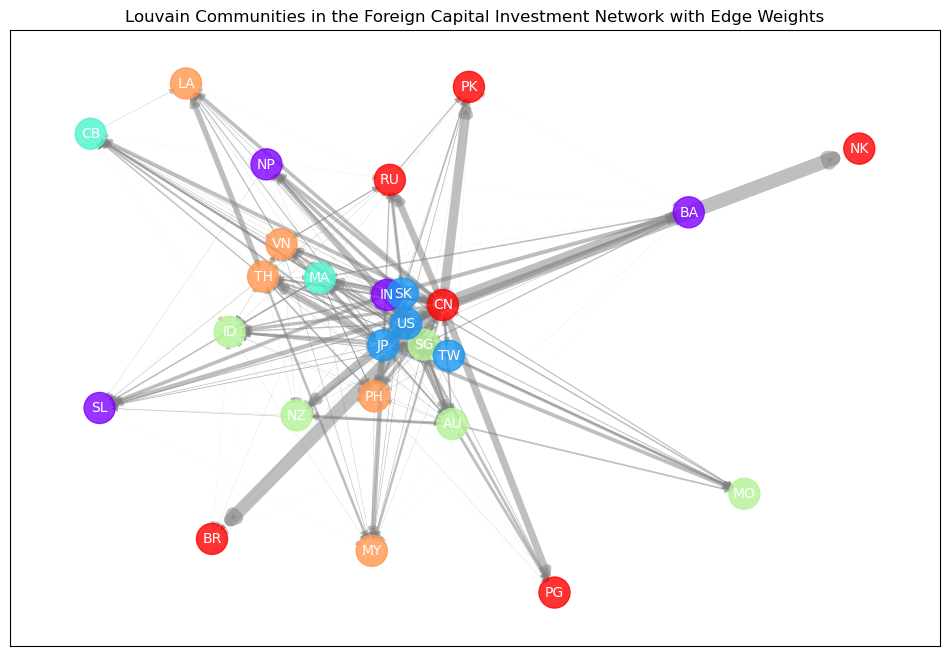

In [97]:
# Perform Louvain community detection for fciN network
louvain_partition_fciN = nx_comm.louvain_communities(G_fciN, weight='weight', resolution=1, threshold=1e-07)

# Convert partition to a dictionary for easier interpretation
louvain_communities_fciN = {i: list(community) for i, community in enumerate(louvain_partition_fciN)}

# Display the resulting communities
print(louvain_communities_fciN)

# Calculate Modularity
modularity_score_fciN = nx_comm.modularity(G_fciN, louvain_partition_fciN, weight='weight')
print(f"Modularity (fciN): {modularity_score_fciN:.3f}")

# Normalise edge weights for fciN network
max_weight_fciN = max(nx.get_edge_attributes(G_fciN, 'weight').values())
min_weight_fciN = min(nx.get_edge_attributes(G_fciN, 'weight').values())
norm_edge_weights_fciN = [(d['weight'] - min_weight_fciN) / (max_weight_fciN - min_weight_fciN) for _, _, d in G_fciN.edges(data=True)]

num_communities_fciN = len(louvain_communities_fciN)
colours_fciN = cm.rainbow(np.linspace(0, 1, num_communities_fciN))
colour_map_fciN = {i: colours_fciN[i] for i in louvain_communities_fciN.keys()}

# Correct the node colours assignment based on louvain_communities dictionary
node_community_map_fciN = {node: community for community, nodes in louvain_communities_fciN.items() for node in nodes}
node_colours_fciN = [colour_map_fciN[node_community_map_fciN[node]] for node in G_fciN.nodes]

# Draw the graph with community colouring for fciN network
pos_fciN = nx.spring_layout(G_fciN, seed=42)
plt.figure(figsize=(12, 8))

# Draw nodes with community colours
nx.draw_networkx_nodes(G_fciN, pos_fciN, node_size=500, node_color=node_colours_fciN, alpha=0.8)
nx.draw_networkx_labels(G_fciN, pos_fciN, font_size=10, font_color='white')

# Draw edges with normalized weights
nx.draw_networkx_edges(G_fciN, pos_fciN, width=[w * 10 for w in norm_edge_weights_fciN], alpha=0.5, edge_color='gray')

plt.title("Louvain Communities in the Foreign Capital Investment Network with Edge Weights")
plt.show()

In [99]:
# Define the groupings
grouping_1 = louvain_communities_didN

grouping_2 = louvain_communities_osiR

grouping_3 = louvain_communities_fciN

# Create a function to assign labels to each node
def create_labels(grouping):
    labels = {}
    for community, nodes in grouping.items():
        for node in nodes:
            labels[node] = community
    return labels

# Create labels for each grouping
labels_1 = create_labels(grouping_1)
labels_2 = create_labels(grouping_2)
labels_3 = create_labels(grouping_3)

# Ensure all nodes are considered by filling in missing nodes with a unique label
all_nodes = set(labels_1.keys()).union(labels_2.keys()).union(labels_3.keys())
for node in all_nodes:
    if node not in labels_1:
        labels_1[node] = -1
    if node not in labels_2:
        labels_2[node] = -1
    if node not in labels_3:
        labels_3[node] = -1

# Create lists of labels for ARI calculation
labels_list_1 = [labels_1[node] for node in sorted(all_nodes)]
labels_list_2 = [labels_2[node] for node in sorted(all_nodes)]
labels_list_3 = [labels_3[node] for node in sorted(all_nodes)]

# Calculate ARI between groupings
ari_1_2 = adjusted_rand_score(labels_list_1, labels_list_2)
ari_1_3 = adjusted_rand_score(labels_list_1, labels_list_3)
ari_2_3 = adjusted_rand_score(labels_list_2, labels_list_3)

print(f"ARI between grouping 1 and grouping 2: {ari_1_2:.3f}")
print(f"ARI between grouping 1 and grouping 3: {ari_1_3:.3f}")
print(f"ARI between grouping 2 and grouping 3: {ari_2_3:.3f}")


ARI between grouping 1 and grouping 2: 0.324
ARI between grouping 1 and grouping 3: 0.199
ARI between grouping 2 and grouping 3: 0.188
